In [1]:
import os
import numpy as np
from numpy import savetxt
import pandas as pd
import glob
import matplotlib.pyplot as plt

from IPython.display import display, HTML

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.preprocessing.sequence import TimeseriesGenerator

from scipy.io import loadmat

import sklearn as sk
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn.svm import SVC   #for Support Vector Machine (SVM) Algorithm
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing

from timeit import default_timer as timer 
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.optimizers import Adam

import sys
sys.path.append('C:/GitHub/ML_models/Whether_Project/')
from custumBoost_matrix import CustomFeatureFabrique  

import pickle
import re

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#import pydot, graphviz

Num GPUs Available:  1


In [116]:
class Subject_Data:
    def __init__(self, subject = 1, lab = 'n/a', directory = 'n/a',new = 0):
        self.subject  = subject
        self.lab = lab
        self.directory = directory
        self.data = []
        self.mask = []
        items = os.listdir(directory)
        self.folders = [os.path.abspath(os.path.join(directory, item)) for item in items if os.path.isdir(os.path.join(directory, item))]
        self.folder_path = os.getcwd()
        self.final_folders = self.get_last_folders('K_fold')
        self.data, self.mask = self.load_data_mask_pickle(subject+'_','true')
        self.new = new
        self = self.start_data()

    # # this prints info from the subject
    # def print_info(self):
    #     print(f'Subject: {self.subject}')
    #     print(f'Lab: {self.lab}')
    #     print(f'Directory: {self.directory}')
    #     print(folders)

    # # this Prints it directly after asking to print(self)
    #def __str__(self):
    #    return f'Subject: {self.subject}; Lab: {self.lab}; Directory: {self.directory}, Folders: {self.folders}'

    def print_all_info(self):
        for attr_name, attr_value in self.__dict__.items():
            print(f'{attr_name}: {attr_value}')

    ## THIS LOADS THE DATA AND MASKS IF IT EXISTS
    def load_data_mask_pickle(self, text1, text2):
        #text = text+'_'
        #print(text)
        pickle_files = [file for file in os.listdir(self.folder_path) if file.endswith(".pkl") and file.startswith(self.subject) and text2 in file]

        if not pickle_files:
            print("No pickle files found in the folder.")
            return None, None

        filtered_data_files = [file for file in pickle_files if str(self.subject) in file and 'data' in file]
        filtered_mask_files = [file for file in pickle_files if str(self.subject) in file and 'mask' in file]

        if not filtered_data_files or not filtered_mask_files:
            print(f"No matching pickle files found for number {self.subject} and lab {self.lab}.")
            return None, None

        # Sort the filtered pickle files by modification time to get the last one
        filtered_data_files.sort(key=lambda x: os.path.getmtime(os.path.join(self.folder_path, x)), reverse=True)
        filtered_mask_files.sort(key=lambda x: os.path.getmtime(os.path.join(self.folder_path, x)), reverse=True)

        data, mask = [], []

        for file_type, data_list in [(filtered_data_files, data), (filtered_mask_files, mask)]:
            last_pickle_path = os.path.join(self.folder_path, file_type[0])

            with open(last_pickle_path, 'rb') as file:
                while True:
                    try:
                        chunk_data = pickle.load(file)
                        data_list.extend(chunk_data)
                    except EOFError:
                        break

            print(f"Loaded {file_type[0].split('.')[0]} from {last_pickle_path}")

        return data, mask

    ## THIS FINDS THE DEEPEST FOLDERS
    def get_last_folders(self, text):
        last_folders = []
        for root, dirs, files in os.walk(self.directory):
            # If there are no subdirectories in the current directory, it's a "last" folder
            if text in root:
                if not dirs:
                    last_folders.append(root)
        
        print(f'Last folders with {text}: {last_folders}')
        return last_folders

    def start_data(self):
        self.mat_files = glob.glob(os.path.join(self.final_folders[0], "*.mat"))
        self.num_files = len(self.mat_files)
        #loaded = 0
        if self.new == 0:
            print("Data is already loaded.")
            [self.experiment,self.phase,self.stimulus,self.split] = self.mask
            self.data = np.array(self.data)
            #num_splits = len(folders_list)
            self.num_splits = 5
        else:
            # Get a list of all .mat files in the folder
            print("Creating empty variables to load data.")
            self.mat_files = glob.glob(os.path.join(self.final_folders[0][0], "*.mat"))

            #num_splits = len(folders_list)
            self.num_splits = 5

            # Preallocate arrays to the correct length
            
            if 'cha'  in self.lab or 'tel' in self.lab:
                print(f'lab is {self.lab} so file is 64 by 531')
                self.data = np.empty((self.num_files, 64, 531))  # Replace 'height' and 'width' with your actual data dimensions
            else:
                print(f'lab is {self.lab} so file is 59 by 519')
                self.data = np.empty((self.num_files, 59, 519))

            self.phase = [None] * self.num_files
            self.stimulus = [None] * self.num_files
            self.experiment = [None] * self.num_files
            self.split = [None] * self.num_files

        return self
    
    # CREATES A NEW DATASET
    def create_new_dataset(self, save = 1):
        self.new = 1
        self.start_data()
        
        #for j, folder in enumerate(self.final_folders):
        #print(f'Loading folder {folder}')
        mat_files = glob.glob(os.path.join(self.final_folders[0], "*.mat"))
        
        #if not mat_files:
        #    continue

        for i, file_path in enumerate(mat_files):
            print(f'Loading file {file_path} number {i}')
            mat_data = loadmat(file_path)
            data = mat_data.get('epoch')
            if data is None or data.dropna().empty:
                print(f'File {file_path} is empty')
                continue
            if not data.any()
                
            self.data[i] = data[:,:]
            #print(self.data[i])

            file_name = os.path.basename(file_path)
            number = int(file_name[file_name.find('fold_') + 5 : file_name.find('fold_') + 6])
            kfold = ['train'] * 5
            kfold[number-1] = 'test'
            self.split[i] = kfold

            if 'IB' in file_name:

                self.experiment[i] = 'IB'

                if '210ep' in file_name:
                    self.stimulus[i] = 'face'
                    self.phase[i] = 'invisible'
                elif '220ep' in file_name:
                    #continue
                    self.stimulus[i] = 'face'
                    self.phase[i] = 'visible'
                elif '230ep' in file_name:
                    continue
                    self.stimulus[i] = 'face'
                    self.phase[i] = 'reported'

                elif '211ep' in file_name:
                    self.stimulus[i] = 'house'
                    self.phase[i] = 'invisible'
                elif '221ep' in file_name:
                    #continue
                    self.stimulus[i] = 'house'
                    self.phase[i] = 'visible'
                elif '231ep' in file_name:
                    continue
                    self.stimulus[i] = 'house'
                    self.phase[i] = 'reported'

                elif '212ep' in file_name:
                    self.stimulus[i] = 'noise'
                    self.phase[i] = 'invisible'
                elif '222ep' in file_name:
                    #continue
                    self.stimulus[i] = 'noise'
                    self.phase[i] = 'visible'
                elif '232ep' in file_name:
                    continue
                    self.stimulus[i] = 'noise'
                    self.phase[i] = 'reported'
                    
            elif 'BM' in file_name:

                self.experiment[i] = 'BM'

                if '10ep' in file_name:
                    self.stimulus[i] = 'face'
                    self.phase[i] = 'visible'
                elif '11ep' in file_name:
                    self.stimulus[i] = 'face'
                    self.phase[i] = 'invisible'
                elif '12ep' in file_name:
                    self.stimulus[i] = 'house'
                    self.phase[i] = 'visible'
                elif '13ep' in file_name:
                    self.stimulus[i] = 'house'
                    self.phase[i] = 'invisible'
                elif '14ep' in file_name:
                    self.stimulus[i] = 'noise'
                    self.phase[i] = 'visible'
                elif '15ep' in file_name:
                    self.stimulus[i] = 'noise'
                    self.phase[i] = 'invisible'

            elif 'DC' in file_name:

                self.experiment[i] = 'DC'

                if 'e11ep' in file_name:
                    self.stimulus[i] = 'face'
                    self.phase[i] = 'visible'
                elif 'e12ep'  in file_name:
                    self.stimulus[i] = 'face'
                    self.phase[i] = 'visible'
                elif 'e61ep' in file_name:
                    self.stimulus[i] = 'face'
                    self.phase[i] = 'invisible'
                elif 'e62ep' in file_name:
                    self.stimulus[i] = 'face'
                    self.phase[i] = 'invisible'
                elif 'e21ep'  in file_name:
                    self.stimulus[i] = 'house'
                    self.phase[i] = 'visible'
                elif 'e22ep' in file_name:
                    self.stimulus[i] = 'house'
                    self.phase[i] = 'visible'
                elif 'e71ep' in file_name:
                    self.stimulus[i] = 'house'
                    self.phase[i] = 'invisible'
                elif 'e72ep' in file_name:
                    self.stimulus[i] = 'house'
                    self.phase[i] = 'invisible'
                elif 'e31ep' in file_name:
                    self.stimulus[i] = 'noise'
                    self.phase[i] = 'visible'
                elif 'e32ep' in file_name:
                    self.stimulus[i] = 'noise'
                    self.phase[i] = 'visible'
                elif 'e81ep'  in file_name:
                    self.stimulus[i] = 'noise'
                    self.phase[i] = 'invisible'
                elif 'e82ep' in file_name:
                    self.stimulus[i] = 'noise'
                    self.phase[i] = 'invisible'
            
            self.experiment = np.array(self.experiment)
            self.phase = np.array(self.phase)
            self.stimulus = np.array(self.stimulus)
            #self.split = np.array(self.split)

            all_masks = [self.experiment, self.phase, self.stimulus, self.split]
            # Create masks
            self.IB_mask, self.DC_mask, self.BM_mask, self.h_mask, self.f_mask, self.n_mask, self.vis_mask, self.invis_mask, self.test_mask, self.train_mask = self.create_masks(self.experiment, self.phase, self.stimulus, self.split)

        #self.data = np.array(self.data)
        self.mask = all_masks

        return self

        if save == 1:
            print('Saving files mask and data')
            with open(f'{subject}_{num_splits}_folds_true_clean_{num_files}_trials_pipeline_data.pkl', 'wb') as f:
                pickle.dump(all_data, f)
            with open(f'{subject}_{num_splits}_folds_true_clean_{num_files}_trials_pipeline_masks.pkl', 'wb') as f:
                pickle.dump(all_masks, f)

    def create_masks(self, experiment,phase,stimulus,split):

        IB_mask = (experiment == 'IB')
        DC_mask = (experiment == 'DC')
        BM_mask = (experiment == 'BM')

        h_mask = (stimulus == 'house')
        f_mask = (stimulus == 'face')
        n_mask = (stimulus == 'noise')

        vis_mask = (phase == 'visible')
        invis_mask = (phase == 'invisible')

        test_mask = (split == 'test')
        train_mask = (split == 'train')

        return IB_mask,DC_mask,BM_mask,h_mask,f_mask,n_mask,vis_mask,invis_mask,test_mask,train_mask

    def print_all_info(self):
        for attr_name, attr_value in self.__dict__.items():
            print(f'{attr_name}: {attr_value}')



SyntaxError: invalid syntax (1509392602.py, line 134)

In [4]:
import numpy as np

def create_channel_mask(total_channels, excluded_channels):
    """
    Create a boolean mask to exclude specific channels from the data.

    Parameters:
    - total_channels (int): Total number of channels in the data.
    - excluded_channels (list): List of channels to exclude from the data.

    Returns:
    - channel_mask (ndarray): Boolean mask with 1s for included channels and 0s for excluded channels.
    """
    # Initialize a boolean mask with all True (included channels)
    channel_mask = np.ones(total_channels, dtype=bool)
    
    # Set the indices corresponding to excluded channels to False
    channel_mask[excluded_channels] = False
    
    return channel_mask

# Example usage:
#total_channels = 64  # Assuming 64 channels
#excluded_channels = range(49,59)  # Channels to exclude
#excluded_channels = [58,60,61,62,63]
#channel_mask = create_channel_mask(total_channels, excluded_channels)
#print(channel_mask)
#print(channel_mask.shape)

In [5]:
def create_channel_mask(total_channels, excluded_channels):
    """
    Create a boolean mask to exclude specific channels from the data.

    Parameters:
    - total_channels (int): Total number of channels in the data.
    - excluded_channels (list): List of channels to exclude from the data.

    Returns:
    - channel_mask (ndarray): Boolean mask with 1s for included channels and 0s for excluded channels.
    """
    # Initialize a boolean mask with all True (included channels)
    channel_mask = np.ones(total_channels, dtype=bool)
    
    # Set the indices corresponding to excluded channels to False
    channel_mask[excluded_channels] = False
    
    return channel_mask

def shuffle_data(dataset,labels):
    # Create an index array to shuffle the data and labels in the same order
    index = np.arange(len(dataset))
    np.random.shuffle(index)

    # Shuffle the dataset and labels using the index array
    shuffled_dataset = dataset[index]
    shuffled_labels = labels[index]
    return shuffled_dataset, shuffled_labels
    # Now, shuffled_dataset and shuffled_labels contain the data and labels shuffled in the same order

def create_masks(experiment,phase,stimulus,split):

    IB_mask = (experiment == 'IB')
    DC_mask = (experiment == 'DC')
    BM_mask = (experiment == 'BM')

    h_mask = (stimulus == 'house')
    f_mask = (stimulus == 'face')
    n_mask = (stimulus == 'noise')

    vis_mask = (phase == 'visible')
    invis_mask = (phase == 'invisible')

    test_mask = (split == 'test')
    train_mask = (split == 'train')

    return IB_mask,DC_mask,BM_mask,h_mask,f_mask,n_mask,vis_mask,invis_mask,test_mask,train_mask

def create_masks_balanced(experiment):

    IB_mask = (experiment == 'IB')
    DC_mask = (experiment == 'DC')
    BM_mask = (experiment == 'BM')

    # Find the minimum number of trials among the three experiments
    min_num_trials = min(np.sum(IB_mask[0]), np.sum(DC_mask[0]), np.sum(BM_mask[0]))
    
    # Sample the experiments with fewer trials to match the minimum number
    IB_mask_indices = np.where(IB_mask[0])[0]
    DC_mask_indices = np.where(DC_mask[0])[0]
    BM_mask_indices = np.where(BM_mask[0])[0]

    # Select random indices for undersampling
    selected_indices_IB = np.random.choice(IB_mask_indices, size=min_num_trials, replace=False)
    selected_indices_DC = np.random.choice(DC_mask_indices, size=min_num_trials, replace=False)
    selected_indices_BM = np.random.choice(BM_mask_indices, size=min_num_trials, replace=False)

    # Reshape them into the original shape
    reshaped_IB_indices = np.expand_dims(selected_indices_IB, axis=1)
    reshaped_DC_indices = np.expand_dims(selected_indices_DC, axis=1)
    reshaped_BM_indices = np.expand_dims(selected_indices_BM, axis=1)

    # Create new masks with fewer '1's while maintaining original size
    undersampled_IB_mask = np.zeros_like(IB_mask, dtype=bool)
    undersampled_IB_mask[selected_indices_IB] = True

    undersampled_DC_mask = np.zeros_like(DC_mask, dtype=bool)
    undersampled_DC_mask[selected_indices_DC] = True

    undersampled_BM_mask = np.zeros_like(BM_mask, dtype=bool)
    undersampled_BM_mask[selected_indices_BM] = True

    return undersampled_IB_mask,undersampled_DC_mask,undersampled_BM_mask


def reshape_data_ml(data):

    #data = data[~np.all(data == 0, axis=1)]
    if len(data.shape) == 4:

        data = data.reshape(data.shape[0],data.shape[1]*data.shape[2],data.shape[3])
        
        data = data[:,~np.all(data == 0, axis=0)]
    elif len(data.shape) == 3:
        data = data.reshape(data.shape[0],data.shape[1]*data.shape[2])

    #data = data.reshape(data.shape[0],data.shape[1]*data.shape[2])

    #print(data.shape)

    return data

def change_labels_ml(labels):
    lbl_clf = preprocessing.LabelEncoder() #function 
    labels = lbl_clf.fit_transform(labels)
    #print(labels.shape)
    #labels = tf.keras.utils.to_categorical(labels) # transform the data into columns and such
    return labels

def change_labels_cnn(labels):
    lbl_clf = preprocessing.LabelEncoder() #function 
    labels = lbl_clf.fit_transform(labels)
    labels = tf.keras.utils.to_categorical(labels) # transform the data into columns and such
    print(labels.shape)
    return labels

def mask_data2(final_mask,test_mask,label_source,data):

    train_data = data[final_mask,:]
    train_labels = label_source[final_mask]

    test_data = data[test_mask,:]
    test_labels = label_source[test_mask]

    test_data,test_labels = shuffle_data(test_data,test_labels)

    train_data,train_labels = shuffle_data(train_data,train_labels)

    final_data = [(train_data),(train_labels),(test_data),(test_labels)]

    return final_data

def reshape_all(final_data):

    X_train = reshape_data_ml(final_data[0])
    X_test = reshape_data_ml(final_data[2])
    y_train = change_labels_ml(final_data[1])
    y_test = change_labels_ml(final_data[3])

    data = [X_train,X_test,y_train,y_test]

    return data

def plot_avg_ERP(data):

    import numpy as np
    import matplotlib.pyplot as plt

    # Assuming 'data' is your 3D array [epoch, channel, time-points]

    # Calculate the average across epochs to get ERPs
    erp_data = np.mean(data, axis=0)

    # Get the time points for x-axis
    time_points = np.arange(data.shape[2])  # Assuming time is the third dimension

    # Plot ERPs for all channels
    num_channels = data.shape[1]
    plt.figure(figsize=(10, 6))

    for channel in range(num_channels):
        plt.plot(time_points, erp_data[channel, :], label=f'Channel {channel + 1}')

    plt.xlabel('Time Points')
    plt.ylabel('Amplitude')
    plt.title('Event-Related Potentials (ERPs) for All Channels')
    #plt.legend()
    plt.show()

def run_model(dataset,model,title,combination):

    print(f"Running model {title}, {combination}")
    #print(model)
    model.fit(dataset[0],dataset[2])
    prediction = model.predict(dataset[1])
    print(f"The accuracy of the {title} , {combination} is {metrics.accuracy_score(prediction,dataset[3])}")
    print(f"The Area Under the Curve of the {title} , {combination} is {metrics.roc_auc_score(prediction,dataset[3])}")

    return model,prediction

def normalize_data(data):

    from sklearn.preprocessing import MinMaxScaler

    # Assuming 'data' is your input data
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)

    return normalized_data

def mask_data_multipletests(train_mask,test_mask,label_source,data,round_name):
    #print(all_data)
    #print(train_mask.shape)
    #print(np.sum(data))
    train_data = data[train_mask]
    
    true_indices = [index for index, value in enumerate(train_mask) if value]
    #print(true_indices)
    train_labels = label_source[train_mask]
    all_test_data = []
    all_tests_labels = []
    #print(test_mask.shape)
    for tests in test_mask:
        #print(tests.shape)
        #print(any(tests))
        test_data = data[tests,...]
        test_labels = label_source[tests]

        #print(test_data)
        test_data,test_labels = shuffle_data(test_data,test_labels)
        all_test_data.append(test_data)
        #print(test_labels)
        all_tests_labels.append(test_labels)

    train_data,train_labels = shuffle_data(train_data,train_labels)
    #print('all test data', all_test_data)
    #print('all test labels', all_tests_labels)

    final_data = [(train_data),(train_labels),(all_test_data),(all_tests_labels),round_name]

    return final_data

def clean_nones(mask):
    #mask = np.array(mask)
    mask2 = mask != None
    mask3 = mask[mask2] 
    #mask4 = mask3.reshape(mask.shape[0],-1)
    return mask3

def clean_nones_all_data(data):
    #mask = np.array(mask)
    # Create a boolean mask indicating rows with all zeros
    mask = np.any(data != 0, axis=2)

    # Select only the rows that do not contain all zeros
    filtered_array = data[mask]
    return filtered_array

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001
# Create the optimizer with the custom learning rate
optimizer = Adam(learning_rate=learning_rate)

# For train test between different experiments

cnn = tf.keras.models.Sequential() # sequential mode 99% of the time;

In [7]:
# Importing Lucas/Dimitri function
from timeit import default_timer as timer 
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.optimizers import Adam

import sys
sys.path.append('C:/GitHub/ML_models/Whether_Project/')
from custumBoost_matrix import CustomFeatureFabrique  

def Haar_wavelet2(all_data):
    import sys
    sys.path.append('C:/GitHub/ML_models/Whether_Project/')

    from custumBoost_matrix import CustomFeatureFabrique

    feature_factory = CustomFeatureFabrique(all_data, sampling_freq=500)
    feature_factory.generate_wavelet_parameters()

    feature_factory.generate_monophasic_wavelets(is_to_plot = False)
    feature_factory.generate_biphasic_wavelets(is_to_plot = False)
    
    bi_features = feature_factory.generate_biphasic_convolution_features()
    mono_features = feature_factory.generate_monophasic_convolution_features()
    #reg_features = feature_factory.generate_regression_features()
    
    bi_features = np.array(bi_features)
    bi_features = np.transpose(bi_features, (1, 2, 0))
    #print(bi_features.shape)
    mono_features = np.array(mono_features)
    mono_features = np.transpose(mono_features, (1, 2, 0))
    #print(mono_features.shape)

    #reg_features = np.array(reg_features)
    #print(reg_features.shape)

    #reg_features = np.transpose(reg_features, (2, 1, 0))
    #print(reg_features.shape)
    
    all_features = np.append(mono_features,bi_features,axis=2)
    #all_features = np.append(all_features,reg_features,axis=2)

    return all_features,mono_features,bi_features
    
#all_features, mono_features,bi_features = Haar_wavelet(all_data)


In [8]:
def average_trials_nosubs(data, labels, avg_num):
    averaged_data = []
    averaged_labels = []
    print(data.shape)

    # Separate data based on labels
    unique_labels = np.unique(labels)
    for label in unique_labels:
        #print("RUNNING")
        label_data = data[labels == label]
        num_trials = label_data.shape[0]
        num_batches = num_trials // avg_num

        # Loop over the data averaging every 8 trials
        for i in range(num_batches):
            start_index = i * avg_num
            end_index = start_index + avg_num
            batch_data = label_data[start_index:end_index]
            averaged_trial = np.mean(batch_data, axis=0)
            averaged_data.append(averaged_trial)
            averaged_labels.append(label)

    return np.array(averaged_data), np.array(averaged_labels)

In [9]:
import numpy as np

def average_trials(data, labels, average_trials=5):
    averaged_data = []
    averaged_labels = []

    # Separate data based on labels
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_data = data[labels == label]
        num_trials = label_data.shape[0]
        
        # Calculate number of batches needed to sample with substitution
        num_batches = int(np.ceil(len(label_data) / average_trials))

        # Loop over the data and collect averages with substitution
        for _ in range(num_trials):
            # Sample with replacement
            indices = np.random.choice(len(label_data), average_trials, replace=True)
            batch_data = label_data[indices]
            
            # Compute average and append to list
            averaged_trial = np.mean(batch_data, axis=0)
            averaged_data.append(averaged_trial)
            averaged_labels.append(label)

    return np.array(averaged_data), np.array(averaged_labels)


In [10]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

def run_cnn(X_train,y_train,X_test, y_test):
    

    std_clf = StandardScaler() # standardize the data

    scaler = StandardScaler()

    lbl_clf = preprocessing.LabelEncoder() #function 
    print(y_train)
    print(y_test)
    y_train = lbl_clf.fit_transform(y_train)
    y_test = lbl_clf.fit_transform(y_test)
    # encode output to classes
    print(y_train)
    print(y_test)
    y_train = tf.keras.utils.to_categorical(y_train) # transform the data into columns and such
    y_test = tf.keras.utils.to_categorical(y_test) # transform the data into columns and such

    print(X_train.shape)
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    tf.keras.backend.clear_session() # if we dont do that, if you would rerun this, it would take the previous model

    learning_rate = 0.001
    # Create the optimizer with the custom learning rate
    optimizer = Adam(learning_rate = learning_rate)

    # For train test between different experiments

    cnn = tf.keras.models.Sequential() # sequential mode 99% of the time;

    cnn.add(Flatten(input_shape=(X_train.shape[0:])))
    #model.add(Conv2D(32,(2,2),activation='relu',input_shape=(X_train.shape[1:])))
    cnn.add(Dense(100, activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.3))
    #model.add(Flatten())
    #model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.5))
    cnn.add(Dense(100, activation='relu'))
    cnn.add(Dropout(0.3))
    cnn.add(tf.keras.layers.Dense(y_test.shape[1], activation='relu', name='output'))
    # Set the learning rate
    
    loss = 'categorical_crossentropy',  # Choose a loss function
    metrics = 'accuracy',  # Choose evaluation metrics
    num_epochs = 10,  # Set the default number of epochs
    batch_size = 10,  # Set the default batch size
    verbose = 1,  # Set the default verbosity level (0 for silent, 1 for progress bar, 2 for one line per epoch)
    validation_split = 0.25  # Set the default validation split

    cnn.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    print(cnn.summary())

    history = cnn.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=verbose,validation_split=validation_split)
    #cnn.fit(X_train, y_train, nb_epoch=20, batch_size=20, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
    cnn.evaluate(X_test, y_test)

    return cnn

In [11]:
import datetime

class This_Pipeline:
    def __init__(self, subject, all_data, round_robins, models, models_names, steps, windows, averages, percent, mods):
        # data
        self.subject = subject
        self.subject.data = [] # CLEANS THE DATASET OUT OF THE RUN FOR FILESIZE
        self.final_data = final_data
        self.round_robins = round_robins
        self.description = mods
        # variables for all the pipeline runs
        self.steps = steps
        self.windows = windows
        self.averages = averages
        self.percent = percent
        self.models = models
        self.models_names = models_names
        #self.channels = channels_mask

        self.runs = []

    def print_info(self):
        print(f'Subject: {self.subject}')
        print(f'Steps: {self.steps}')
        print(f'Windows: {self.windows}')
        print(f'Averages: {self.averages}')
        print(f'Percent: {self.percent}')
        print(f'Models: {self.models}')
        print(f'Mods: {self.mods}')

    def run_models(self):

        self.model_outputs = []

        count = 0

        for i, model in enumerate(self.models):
            self.all_models_runs = []   
            for n, avg_num in enumerate(self.averages):
                self.all_avg_runs = []
                for j, window_size in enumerate(self.windows):
                    self.all_split_runs = []
                    for m, splits in enumerate(self.final_data): # LOOP OVER ALL SPLITS
                        self.all_round_runs = []
                        filename = f'{self.subject.lab}_su{self.subject.subject}_{self.models_names[i]}_{self.description}_{window_size}_step_{self.steps[j]}_{self.subject.num_splits}fold_{avg_num}avg'
                        for l, data in enumerate(splits): # LOOP OVER ALL ROUND
                            number_of_models = int((data[0].shape[2] - window_size + 1)/step_size[j])
                            
                            window_names = f"model {i+1}/{len(models)}, avg {avg_num}, window {j+1}/{len(window_sizes)}, split {m+1}/{len(final_data)}, round {l+1}/{len(splits)}, {round_robins[l]}, {models_names[i]}, Iteration {j}, window_size = {window_size}, {number_of_models} models, Style {mods}"
                            print(window_names)
                            start = timer()
                            
                            #hyper_scores[count], hyper_models[count], hyper_AUC[count] = moving_window(round_X_dataset,number_of_models,window_size,step_size,model,window_of_time)
                            
                            this_run = This_Run(self.subject, data, self.round_robins[l], self.steps[j], window_size, avg_num, model, self.percent, self.description)
                            #this_run = This_Run(subject, final_data[0][0], round_robins[0], step=5, window=40, average=8, model=logreg, percent=100, mods='test')
                            self.all_round_runs.append(this_run.moving_window_subsample())
                            #self.all_round_runs.append(moving_window_subsample(round_X_dataset,number_of_models,window_size,step_size[j],model,window_of_time,percent,haar,mods,channels,round_robins[l],avg_num,filename))
                            #print(outputs)

                            print("Moving window time:", timer()-start) 
                        self.all_split_runs.append(self.all_round_runs)
                    #current_datetime = datetime.datetime.now()
                    #formatted_datetime = current_datetime.strftime("%Y-%m-%d_%Hh-%Mm-%Ss")
                    
                    #with open(f'{filename}_{formatted_datetime}.pkl', 'wb') as f:
                    #    pickle.dump(self.all_split_runs, f)
            
                    #self.all_model_runs.append(all_split_runs)
                    self.all_avg_runs.append(self.all_split_runs)
                self.all_models_runs.append(self.all_avg_runs)
            self.model_outputs.append(self.all_models_runs)

            # Get the current date and time
            current_datetime = datetime.datetime.now()

            # Format the date and time as a string
            formatted_datetime = current_datetime.strftime("%Y-%m-%d_%Hh-%Mm-%Ss")
            with open(f'complete_run_{filename}_{formatted_datetime}.pkl', 'wb') as f:
                pickle.dump(self.model_outputs, f)

        return self


In [110]:
from sklearn import metrics
from confidenceinterval import roc_auc_score
import copy
from timeit import default_timer as timer 
#from tdqm import tdqm

class This_Run:
    def __init__(self, subject, data, round_robin, step, window, average, model, percent, mods):
        # Data, Labels, Subject
        self.subject = subject
        self.subject.data = [] # CLEANS THE DATASET OUT OF THE RUN FOR FILESIZE
        self.dataset = data
        self.pipeline_labels = round_robin
        self.description = mods
        # Variables and Hyperparameters
        self.step = step
        self.window = window
        self.average = average
        self.percent = percent
        self.model = model
        #self.channels = channels_mask

    def print_info(self):
        print(f'Subject: {self.subject}')
        print(f'Steps: {self.step}')
        print(f'Windows: {self.window}')
        print(f'Averages: {self.average}')
        print(f'Percent: {self.percent}')
        print(f'Models: {self.models}')
        print(f'Mods: {self.mods}')

    def moving_window_subsample(self):
        # create empty variables
        scores = []
        models = []
        predictions = []
        aucs = []
        f1scores = []
        auc2s = []
        cis = []

        # collect data from the dataset variable
        train_data = self.dataset[0]
        train_labels = self.dataset[1]
        all_test_data = self.dataset[2]
        all_test_labels = self.dataset[3]
        self.dataset = [] # CLEANS THE DATASET OUT OF THE RUN FOR FILESIZE
        #print(train_data.shape)
        train_data, train_labels = shuffle_data(train_data, train_labels)
        train_data, train_labels = average_trials(train_data, train_labels, self.average)
        #print(train_data.shape)

        # THIS RANDOMIZES THE DATA AND ALLOWS FOR SUB-SELECTION OF DATA FOR SMALLER TEST TRAININGS
        X_tr = train_data.shape[0]
        num_ones_tr = int(X_tr * (self.percent / 100)) # Calculate the number of 1s based on the percentage
        random_array_train = np.random.choice([False, True], size=X_tr, p=[(100 - self.percent) / 100, self.percent / 100]) # Generate the array with the specified percentage of 1s
        
        # Starts the loop for timewindows of the test data.
        self.array_of_windows = enumerate(range(window_of_time[0], (train_data.shape[2] - self.window -1), self.step))
        #print(self.array_of_windows)

        for k, start_time in enumerate(range(0, (train_data.shape[2] - self.window -1), self.step)):
            start = timer()
            end_time = start_time + self.window
            
            ### TRAIN ###

            # Use random array to select train data to be run
            train_data_win = train_data[random_array_train,:,start_time:end_time]
            y_train = train_labels[random_array_train]  

            # perform Haar transformation if necessary
            if haar:
                train_data_win,mono,bi = Haar_wavelet2(train_data_win)

            # test for shape, make sure it's in 2D for MLs
            X_test = []
            X_train = []

            if len(train_data_win.shape) == 3:
                X_train = train_data_win.reshape(train_data_win.shape[0],train_data_win.shape[1]*train_data_win.shape[2])
            else:
                X_train = train_data_win
            
            X_train = normalize_data(X_train)
            y_train = change_labels_ml(y_train)

            ### RUN THE MODEL ###
            classifier = self.model
            classifier.fit(X_train,y_train)
            #print_mean_coeff(classifier.coef_,0)

            models.append(copy.deepcopy(classifier))

            ### TEST ###

            # initializing variables for test_data
            comparing_test_data_win = []
            test_data_each_win = []
            comparing_label_data_win = []
            y_test_each_win = [] 

            # initialize variables to store scores
            prediction = []
            results = []
            score = []
            f1score = []
            auc = []
            auc2 = []
            ci = []
            y_test = []
            random_array_test = []

            start_time2_array = []

            # DO ALL TEST DATA THINGS FIRST
            # THEN LOOP THROUGH ALL TEST DATA Possibilities
            for i, test in enumerate(all_test_data):
                #print(test)
                labels_test = all_test_labels[i]
                test, labels_test = shuffle_data(test, labels_test)
                test, labels_test = average_trials(test, labels_test, self.average)
                y_test = []
                X_test = []
                title_test = []
                # DO LOOPS THROUGH ALL THE POSSIBLE TIME-WINDOWS
                for j, start_time2 in enumerate(range(window_of_time[0], (train_data.shape[2] - self.window -1), self.step)):
                    #print(j)
                    end_time2 = start_time2 + self.window
                    start_time2_array.append(start_time2)
                    # randomly subsample the data
                    ### DATA ###
                    X_te = test.shape[0]
                    num_ones_te = int(X_te * (self.percent / 100))
                    random_array_test = np.random.choice([False, True], size=X_te, p=[(100 - self.percent) / 100, self.percent / 100])

                    # select subsample and window of the data
                    #print(test.shape)
                    selected_test = test[random_array_test,:,start_time2:end_time2] # FILTER THE DATA FOR TIME AND SUBSAMPLE
                    #print('loop',i)
                    #print('time',j)
                    #print('test data',selected_test)
                    # perform Haar transformation if necessary
                    #if self.haar:
                        #train_data_win,mono,bi = Haar_wavelet2(train_data_win)
                    #    selected_test,mono,bi = Haar_wavelet2(selected_test)

                    # RESHAPE THE DATA
                    if len(train_data_win.shape) == 3:
                        #for test in test_data_win:
                        data_test = selected_test.reshape(selected_test.shape[0],selected_test.shape[1]*selected_test.shape[2])
                    else:
                        #for test in test_data_win:
                        data_test = selected_test
                    data_test = normalize_data(data_test) # NORMALIZE DATA
                    X_test.append(data_test)

                    ### LABELS ###
                    #labels_test = all_test_labels[i]
                    #print(labels_test.shape)
                    labels_test = change_labels_ml(labels_test) # FIX LABELS
                    y_test.append(labels_test[random_array_test])
                    
                # collect all data and labels
                comparing_test_data_win.append(X_test)
                comparing_label_data_win.append(y_test)
            
            #print(np.array(comparing_label_data_win).shape)

            # initialize variables
            #time_predictions = []
            results = []
            score = []
            f1score = []
            auc = []
            auc2 = []
            ci = []
            y_tests = []

            tests_predictions = []
            tests_scores = []
            tests_results = []
            tests_score = []
            tests_f1scores = []
            tests_aucs = []
            tests_auc2s = []
            tests_cis = []
            tests_y_tests = []
            tests_models = []

            # Run all tests, collect all outputs
            for i, X_tests in enumerate(comparing_test_data_win):
                
                score = []
                auc2 = []
                auc = []
                f1score = []
                ci = []

                time_predictions = []
                test_ys = []
                all_tests_predictions = []
                #models = []

                theselabels = comparing_label_data_win[i]
                for j, X_test in enumerate(X_tests):
                    #print(j)
                    #print('loop',i)
                    #print('time',j)
                    test_y = theselabels[j]
                    y_pred = copy.deepcopy(classifier.predict(X_test))
                    #print('y pred shape',y_pred.shape)
                    time_predictions.append(y_pred)
                    #print('test data',X_test)
                    #models.append(copy.deepcopy(classifier))

                    score.append(metrics.accuracy_score(y_pred,test_y))
                    try:
                        f1score.append(metrics.f1_score(y_pred,test_y))
                    except:
                        f1score.append(0.5)
                    try:
                        auc.append(metrics.roc_auc_score(y_pred,test_y))
                    except:
                        auc.append(0.5)
                    try:
                        
                        roc_results = roc_auc_score(test_y,
                            y_pred,
                            confidence_level=0.95)
                    except:
                        roc_results = ([0.5],[0.5, 0.5])
                        #roc_results[1] = [0.5, 0.5]

                    auc2.append(roc_results[0])
                    ci.append(roc_results[1])

                    significance = 'NOT sig.'
                    if roc_results[1][0] > 0.50:
                        significance = 'SIG! YES'
                        #if j == i:
                        print(f"Subj. {self.subject.subject} {self.pipeline_labels[i]} #{k} Train time {start_time}, Test time {start_time2_array[j]}, {significance} Low CI:{round(ci[j][0]*100,2)} AUC {round(auc[j]*100,2)}, accuracy {round(score[j]*100,2)},f1 score {round(f1score[j]*100,2)}, {mods}, time:", round(timer()-start,2))
                
                    #print(f"{name[i]}#{k} Train time {start_time}, Test time {start_time2_array[j]}, {significance} Low CI:{round(ci[j][0]*100,2)} AUC {round(auc[j]*100,2)}, accuracy {round(score[j]*100,2)},f1 score {round(f1score[j]*100,2)}, {mods}, time:", round(timer()-start,2))
                    test_ys.append(test_y)
                    tests_predictions.append(copy.deepcopy(time_predictions))

                tests_models.append(copy.deepcopy(models))

                tests_aucs.append(auc)
                tests_auc2s.append(auc2)
                tests_cis.append(ci)
                tests_f1scores.append(f1score)
                
                all_tests_predictions.append(tests_predictions)
                tests_y_tests.append(test_ys)
                tests_scores.append(score)

            aucs.append(tests_aucs)
            auc2s.append(tests_auc2s)
            cis.append(tests_cis)
            f1scores.append(tests_f1scores)
            
            predictions.append(all_tests_predictions)
            y_tests.append(tests_y_tests)
            scores.append(tests_scores)
        
        self.scores = scores
        self.f1scores = f1scores
        self.aucs = aucs
        self.models = models
        #self.tests_predictions = tests_predictions
        self.auc2s = auc2s
        self.cis = cis
        self.y_tests = y_tests
        self.predictions = predictions

        return self

    # Example usage:
    #pipeline = This_pipeline(subject="Subject 1", self.steps=10, windows=5, averages=3, percent=0.8, models=["Model A", "Model B"], mods={"mod1": 1, "mod2": 2})
    #pipeline1 = This_pipeline(subj1, subject, all_data, round_robins, models, self.steps, windows, averages, percent, mods)

    #pipeline1.print_info()


# Example usage:
#pipeline = This_pipeline(subject="Subject 1", self.steps=10, windows=5, averages=3, percent=0.8, models=["Model A", "Model B"], mods={"mod1": 1, "mod2": 2})
#run = This_run(subj1, self.step_size, windows, avgs, percent, models, mods)

#run.print_info()


In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import convolve2d

def print_timebytime(splits):
    """
    Function to plot the average scores over time, along with error bars and binomial probabilities.

    Parameters:
    - step_size: Step size for time windows.
    - splits: List containing three 3D matrices [splits, rounds, scores] for face, house, and noise.
    - window_size: Window size for time windows.

    Returns:
    None (plots the graph and prints binomial probabilities).
    """

    # Collect the auc and CI info from each run
    aucs_array = np.array([[np.array(inner_list.aucs) for inner_list in row] for row in splits])
    cis_array = np.array([[np.array(inner_list.cis) for inner_list in row] for row in splits])

    y_preds = np.array([[np.array(inner_list.tests_predictions) for inner_list in row] for row in splits])
    y_tests = np.array([[np.array(inner_list.y_tests) for inner_list in row] for row in splits])


    roc_results = roc_auc_score(test_y,
                            y_pred,
                            confidence_level=0.95)

    # # Perform one-sample t-test for each AUC value
    min_cis = np.zeros([aucs_array.shape[1],aucs_array.shape[2],aucs_array.shape[3],aucs_array.shape[4]])
    max_cis = np.zeros([aucs_array.shape[1],aucs_array.shape[2],aucs_array.shape[3],aucs_array.shape[4]])
    #p_values = np.zeros_like(heatmap_data)
    bootstrap_aucs = []

    num_bootstrap_samples  = 1000
    bootstrap_samples = np.zeros(num_bootstrap_samples)

    for i in range(aucs_array.shape[1]):
        for j in range(aucs_array.shape[2]):
            for k in range(aucs_array.shape[3]):
                for l in range(aucs_array.shape[4]):
                    y_pred = y_preds[:,i,j,k,l].reshape
                    y_test
                    roc_results = roc_auc_score(test_y,
                            y_pred,
                            confidence_level=0.95)
                    
                    for _ in range(num_bootstrap_samples):
                                #subj, splits, trains, values, test, values 
                        auc_value = np.squeeze(aucs_array[:,i,j,k,l])
                        #auc_value = auc_value.reshape(auc_value.shape[0]*auc_value.shape[1])
                        #print(auc_value.shape)
                        # Perform one-sample t-test against chance level
                        bootstrap_samples = np.random.choice(auc_value, size=auc_value.shape[0], replace=True)
                        # Calculate the mean of the bootstrap sample and append it to bootstrap_means
                        bootstrap_aucs.append(np.mean(bootstrap_samples))
                        # Calculate confidence interval
                    ci_lower, ci_upper = np.percentile(bootstrap_samples, [2.5, 97.5])
                    min_cis[i,j,k,l] = ci_lower
                    max_cis[i,j,k,l] = ci_upper
    #aucs_array = np.array([run.aucs for run in splits])
    #cis_array = np.array([run.cis for run in splits])
    # Calculate averages and standard errors for each time window  
    avg_scores = np.mean(aucs_array, axis=0) # MEAN OVER SPLITS
    
    avg_cis = np.mean(np.array(cis_array), axis=0)
    #min_cis = np.min(np.array(cis_array), axis=0)
    #max_cis = np.max(np.array(cis_array), axis=0)

    # Create a line plot

    fig = plt.figure(figsize=(12, 12))
    
    clrs = sns.color_palette("husl", 5)
    clrs = ['b','g','orange']
    
    #lines = ['-','-','-']
    lscores = []
    lerrors = []
    # Get participant's information
    labels = [label.pipeline_labels for label in splits[0]]
    
    #data_length = splits[0][0].subject.data.shape[2]
    window_size = splits[0][0].window
    step_size = splits[0][0].step

    data_length = (avg_scores.shape[-1] - 1) * step_size + window_size
    print(data_length)

    num_of_tests = avg_scores.shape[0] # CHANGE TO FIT THE NUMBER OF TRAINS AND TESTS
    num_of_trains = avg_scores.shape[2] # CHANGE TO FIT THE NUMBER OF TRAINS AND TESTS
    print('num of trains', avg_scores.shape[0])
    print('num of tests', avg_scores.shape[2])

    fig = plt.figure(figsize=(num_of_trains*4, num_of_tests*4))

    # NEEDS TO BE CORRECTED FOR 512 collections
    time_windows = [i - 60 for i in range(0, (data_length * 2) - (window_size * 2), step_size * 2)]
    # Create a new array with NaN values
    #new_time_windows = np.full_like(time_windows, np.nan)

    # Update every second and third value with the original time windows
    #new_time_windows[::3] = time_windows[::3]
    #time_windows1 = time_windows[::4]

    colors = [(0, 1, 0), (0, 0, 1), (1, 1, 1), (1, 0, 0), (1, 1, 0)]  # Blue, White, Red, yellow
    #colors = [(0, 0, 1),(0.7, 0.7, 1), (1, 1, 1), (1, .7, .7),(1, 0, 0)]  # Blue, White, Red, yellow
    cmap = LinearSegmentedColormap.from_list("Custom_RdBu", colors)
    
    # Define custom smoothing kernel (ignore diagonals)
    kernel = np.array([[1, 1, 0],
                    [1, 2, 1],
                    [0, 1, 1]])
    
    # Plot the averages with error bars

    count = 1
    print(avg_scores.shape)
    
    for i in range(num_of_trains):
        for l in range(num_of_tests):
            
            ax = plt.subplot(num_of_tests,num_of_trains,count)
            
        #if count < 4:
            #print(labels)
            #start_index = labels[l][i].find("Train")
            #test_title = labels[l][i][start_index:len(labels[l][i])].strip()
            #print(test_title)
            
            ax.set_title(labels[l][i], loc='center', fontsize=16, y=1, x = .5)

            heatmap_data = avg_scores[l,:,i,:]
            min_cis_data = min_cis[l,:,i,:]
            max_cis_data = max_cis[l,:,i,:]

             # Normalize kernel
            kernel = kernel / np.sum(kernel)

            # Perform 2D convolution with the custom kernel
            smoothed_data    = convolve2d(heatmap_data, kernel, mode='same', boundary='fill', fillvalue=0)
            smoothed_min_cis = convolve2d(min_cis_data, kernel, mode='same', boundary='fill', fillvalue=0)
            smoothed_max_cis = convolve2d(max_cis_data, kernel, mode='same', boundary='fill', fillvalue=0) 

            pos_data = np.where(smoothed_min_cis > 0.5, 1, 0)
            neg_data = np.where(smoothed_max_cis < 0.5, 1, 0)

            final_data = pos_data + neg_data

            #smoothed_data = smoothed_data * final_data
            # SHOW AND HIDE CBAR
            cbar_bool = True
            ax2 = sns.heatmap(smoothed_data, vmin = 0, vmax = 1, xticklabels = time_windows, yticklabels = time_windows, cmap = cmap,annot=False, square=True, cbar = True)
            original_position = ax.get_position()
            if count != 1:
                cbar_bool = False
                #sns.cbar = cbar_bool
                cbar = ax.collections[0].colorbar
                
                cbar.remove()
                ax.set_position(original_position)
            # HIDE TICKS
            show_every = 12
            for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
                if i % show_every != 0:
                    label.set_visible(False)
                    plt.gca().xaxis.get_major_ticks()[i].set_visible(False)

            for i, label in enumerate(plt.gca().yaxis.get_ticklabels()):
                if i % show_every != 0:
                    label.set_visible(False)
                    plt.gca().yaxis.get_major_ticks()[i].set_visible(False)

            # Plot your heatmap here, and set the x-axis ticks to the new time windows
            #plt.xticks(range(len(new_time_windows)), new_time_windows)
            plt.contour(final_data, colors='black', linestyles='dotted', linewidths=.5, alpha = 0.5)
            #sns.set_palette("RdBu")
            count = count + 1
            start_index = labels[l][0].find("Train")
            end_index = labels[l][0].find("Test")
            #stim = find_word_stim(title)
            between_train_and_iteration = labels[l][0][start_index:end_index].strip()
            new_title = f"Average AUCs, {between_train_and_iteration}"
            
            plt.gca().invert_yaxis()
            # Show the plot
            # PLOT DIAGNOAL
            plt.plot([0, avg_scores.shape[3]], [0, avg_scores.shape[1]], color='black', linestyle='-', linewidth=.5, alpha = 0.3)
            plt.grid(False)
    
    # Creates a new empty subplot emcompassing the whole figure (111)

    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    # Adds the labels to this big new subplot
    plt.xlabel('Test', fontsize=18)
    plt.ylabel('Train', fontsize=18)

    # Annotate the plot with subject information
    sub_info = splits[0][0].subject
    subtitle = f'Sub. {sub_info.subject}, Lab {sub_info.lab}, Model {splits[0][0].model.__class__.__name__}, Average of {splits[0][0].average} Window length {window_size}, Step size {step_size}'

# Add a square at the top right of the plot containing the subject information
#plt.text(0.5, 1.1, info_text, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

# legs = ''
    
    plt.suptitle('\n'+ new_title, fontsize=16)
    plt.figtext(0.5, 0.915, subtitle, ha='center', va='center')
    #filename = f'{models_name[i]}_{mods}_{window_size}_step_{step_size}_{formatted_datetime}_{num_splits}fold_{avg_num}avg'
    plt.savefig( subtitle + new_title + 'subplots' + '.png', format='png')
    plt.show()

# Example usage:
# print_time_window_three_new(step_size, splits_data, window_size)


In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import convolve2d

def print_timebytime_topoplots(splits):
    """
    Function to plot the average scores over time, along with error bars and binomial probabilities.

    Parameters:
    - step_size: Step size for time windows.
    - splits: List containing three 3D matrices [splits, rounds, scores] for face, house, and noise.
    - window_size: Window size for time windows.

    Returns:
    None (plots the graph and prints binomial probabilities).
    """

    # Collect the auc and CI info from each run
    aucs_array = np.array([[np.array(inner_list.aucs) for inner_list in row] for row in splits])
    cis_array = np.array([[np.array(inner_list.cis) for inner_list in row] for row in splits])
    #aucs_array = np.array([run.aucs for run in splits])
    #cis_array = np.array([run.cis for run in splits])
    # Calculate averages and standard errors for each time window  
    avg_scores = np.mean(aucs_array, axis=0) # MEAN OVER SPLITS
    
    # # Perform one-sample t-test for each AUC value
    min_cis = np.zeros([aucs_array.shape[2],aucs_array.shape[3],aucs_array.shape[4]])
    max_cis = np.zeros([aucs_array.shape[2],aucs_array.shape[3],aucs_array.shape[4]])
    #p_values = np.zeros_like(heatmap_data)
    bootstrap_aucs = []

    for i in range(aucs_array.shape[1]):
        for j in range(aucs_array.shape[2]):
            for k in range(aucs_array.shape[3]):
                for l in range(aucs_array.shape[4]):
                            #subj, splits, trains, values, test, values 
                    auc_value = np.squeeze(aucs_array[:,i,j,k,l])
                    auc_value = auc_value.reshape(auc_value.shape[0]*auc_value.shape[1])
                    #print(auc_value.shape)
                    # Perform one-sample t-test against chance level
                    bootstrap_sample = np.random.choice(auc_value, size=auc_value.shape[0], replace=True)
                    # Calculate the mean of the bootstrap sample and append it to bootstrap_means
                    bootstrap_aucs.append(np.mean(bootstrap_sample))
                    # Calculate confidence interval
                    ci_lower, ci_upper = np.percentile(bootstrap_sample, [0.0025, 99.9975])
                    min_cis[i,j,k,l] = ci_lower
                    max_cis[i,j,k,l] = ci_upper

    avg_cis = np.mean(np.array(cis_array), axis=0)
    min_cis = np.min(np.array(cis_array), axis=0)
    max_cis = np.max(np.array(cis_array), axis=0)

    # Create a line plot
    fig = plt.figure(figsize=(12, 12))
    
    clrs = sns.color_palette("husl", 5)
    clrs = ['b','g','orange']
    
    #lines = ['-','-','-']
    lscores = []
    lerrors = []
    # Get participant's information
    labels = [label.pipeline_labels for label in splits[0]]
    
    #data_length = splits[0][0].subject.data.shape[2]
    window_size = splits[0][0].window
    step_size = splits[0][0].step

    data_length = (avg_scores.shape[-1] - 1) * step_size + window_size
    print(data_length)
    num_or_tests = 3 # CHANGE TO FIT THE NUMBER OF TRAINS AND TESTS
    num_of_trains = 3 # CHANGE TO FIT THE NUMBER OF TRAINS AND TESTS


    # NEEDS TO BE CORRECTED FOR 512 collections
    time_windows = [i - 60 for i in range(0, (data_length * 2) - (window_size * 2), step_size * 2)]
    # Create a new array with NaN values
    #new_time_windows = np.full_like(time_windows, np.nan)

    # Update every second and third value with the original time windows
    #new_time_windows[::3] = time_windows[::3]
    #time_windows1 = time_windows[::4]

    colors = [(0, 1, 0), (0, 0, 1), (1, 1, 1), (1, 0, 0), (1, 1, 0)]  # Blue, White, Red, yellow
    #colors = [(0, 0, 1),(0.7, 0.7, 1), (1, 1, 1), (1, .7, .7),(1, 0, 0)]  # Blue, White, Red, yellow
    cmap = LinearSegmentedColormap.from_list("Custom_RdBu", colors)
    
    # Define custom smoothing kernel (ignore diagonals)
    kernel = np.array([[1, 1, 0],
                    [1, 2, 1],
                    [0, 1, 1]])
    
    # Plot the averages with error bars

    count = 1
    print(avg_scores.shape)
    
    for l in range(3):
        for i in range(3):
            
            ax = plt.subplot(3,3,count)
            
        #if count < 4:
            #print(labels)
            start_index = labels[i][l].find("Train")
            test_title = labels[i][l][start_index:len(labels[l][i])].strip()
            #print(test_title)
            
            ax.set_title(labels[i][l], loc='center', fontsize=16, y=1, x = .5)

            heatmap_data = avg_scores[l,:,i,:]
            min_cis_data = min_cis[l,:,i,:,0]
            max_cis_data = max_cis[l,:,i,:,1]

             # Normalize kernel
            kernel = kernel / np.sum(kernel)

            # Perform 2D convolution with the custom kernel
            smoothed_data    = convolve2d(heatmap_data, kernel, mode='same', boundary='fill', fillvalue=0)
            smoothed_min_cis = convolve2d(min_cis_data, kernel, mode='same', boundary='fill', fillvalue=0)
            smoothed_max_cis = convolve2d(max_cis_data, kernel, mode='same', boundary='fill', fillvalue=0) 

            pos_data = np.where(smoothed_min_cis > 0.5, 1, 0)
            neg_data = np.where(smoothed_max_cis < 0.5, 1, 0)

            final_data = pos_data + neg_data

            #smoothed_data = smoothed_data * final_data
            # SHOW AND HIDE CBAR
            cbar_bool = True
            #ax2 = sns.heatmap(smoothed_data, vmin = 0, vmax = 1, xticklabels = time_windows, yticklabels = time_windows, cmap = cmap,annot=False, square=True, cbar = True)
            print_mean_coeff(avg_coefs[i,j],time_windows[j])
            original_position = ax.get_position()
            if count != 1:
                cbar_bool = False
                #sns.cbar = cbar_bool
                cbar = ax.collections[0].colorbar
                
                cbar.remove()
                ax.set_position(original_position)
            # HIDE TICKS
            show_every = 12
            for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
                if i % show_every != 0:
                    label.set_visible(False)
                    plt.gca().xaxis.get_major_ticks()[i].set_visible(False)

            for i, label in enumerate(plt.gca().yaxis.get_ticklabels()):
                if i % show_every != 0:
                    label.set_visible(False)
                    plt.gca().yaxis.get_major_ticks()[i].set_visible(False)

            # Plot your heatmap here, and set the x-axis ticks to the new time windows
            #plt.xticks(range(len(new_time_windows)), new_time_windows)
            plt.contour(final_data, colors='black', linestyles='dotted', linewidths=.5, alpha = 0.5)
            #sns.set_palette("RdBu")
            count = count + 1
            start_index = labels[l][0].find("Train")
            end_index = labels[l][0].find("Test")
            #stim = find_word_stim(title)
            between_train_and_iteration = labels[l][0][start_index:end_index].strip()
            new_title = f"Average AUCs, {between_train_and_iteration}"
            
            plt.gca().invert_yaxis()
            # Show the plot
            # PLOT DIAGNOAL
            plt.plot([0, avg_scores.shape[3]], [0, avg_scores.shape[1]], color='black', linestyle='-', linewidth=.5, alpha = 0.3)
            plt.grid(False)
    
    # Creates a new empty subplot emcompassing the whole figure (111)

    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    # Adds the labels to this big new subplot
    plt.xlabel('Test', fontsize=18)
    plt.ylabel('Train', fontsize=18)

    # Annotate the plot with subject information
    sub_info = splits[0][0].subject
    subtitle = f'Sub. {sub_info.subject}, Lab {sub_info.lab}, Model {splits[0][0].model.__class__.__name__}, Average of {splits[0][0].average} Window length {window_size}, Step size {step_size}'

# Add a square at the top right of the plot containing the subject information
#plt.text(0.5, 1.1, info_text, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

# legs = ''
    
    plt.suptitle('\n'+ new_title, fontsize=16)
    plt.figtext(0.5, 0.915, subtitle, ha='center', va='center')
    #filename = f'{models_name[i]}_{mods}_{window_size}_step_{step_size}_{formatted_datetime}_{num_splits}fold_{avg_num}avg'
    plt.savefig( subtitle + new_title + 'subplots' + '.png', format='png')
    plt.show()

# Example usage:
# print_time_window_three_new(step_size, splits_data, window_size)


In [31]:
# TRAIN ALL TEST INDIVIDUALLY

# round robin 1

def apply_masks(subj1,IB_mask,DC_mask,BM_mask,h_mask,f_mask,n_mask,vis_mask,invis_mask,test_mask,train_mask,experiment2,phase2,stimulus2,split2):
    final_data = []
    # TRAIN DC

    for i in range(subj1.num_splits):
        print(i)
        final_mask = []
        split_data = []
        final_test_mask = []
        final_test_mask_groups = []
        
        round_robin = []
        round_robins = []

        final_mask.append([(f_mask+h_mask)*(train_mask[:,i])])
        final_test_mask.append([(f_mask+h_mask)*(test_mask[:,i])])
        final_test_mask.append([(f_mask+h_mask)*(DC_mask)*(test_mask[:,i])])
        final_test_mask.append([(f_mask+h_mask)*(IB_mask)*(test_mask[:,i])])
        final_test_mask.append([(f_mask+h_mask)*(BM_mask)*(test_mask[:,i])])
        round_robin.append('Train ALL Test ALL')
        round_robin.append('Train ALL Test DCF')
        round_robin.append('Train ALL Test IB')
        round_robin.append('Train ALL Test BM')
        final_test_mask_groups.append(final_test_mask)
        round_robins.append(round_robin)
        round_robin = []
        final_test_mask = []

        # final_mask.append([(f_mask+h_mask)*(DC_mask)*(train_mask[:,i])])
        # final_test_mask.append([(f_mask+h_mask)*(h_mask)*(DC_mask)*(test_mask[:,i])])
        # final_test_mask.append([(f_mask+h_mask)*(h_mask)*(IB_mask)*(test_mask[:,i])])
        # final_test_mask.append([(f_mask+h_mask)*(h_mask)*(BM_mask)*(test_mask[:,i])])
        # round_robin.append('Train DCF Test DCF')
        # round_robin.append('Train DCF Test IB')
        # round_robin.append('Train DCF Test BM')
        # final_test_mask_groups.append(final_test_mask)
        # round_robins.append(round_robin)
        # round_robin = []
        # final_test_mask = []

        # final_mask.append([(h_mask)*(DC_mask)*(train_mask[:,i])])
        # final_test_mask.append([(h_mask)*(DC_mask)*(test_mask[:,i])])
        # final_test_mask.append([(h_mask)*(IB_mask)*(test_mask[:,i])])
        # final_test_mask.append([(h_mask)*(BM_mask)*(test_mask[:,i])])
        # round_robin.append('House, Train DCF Test DCF')
        # round_robin.append('House, Train DCF Test IB')
        # round_robin.append('House, Train DCF Test BM')
        # final_test_mask_groups.append(final_test_mask)
        # round_robins.append(round_robin)
        # round_robin = []
        # final_test_mask = []

        # final_mask.append([(n_mask)*(DC_mask)*(train_mask[:,i])])
        # final_test_mask.append([(n_mask)*(DC_mask)*(test_mask[:,i])])
        # final_test_mask.append([(n_mask)*(IB_mask)*(test_mask[:,i])])
        # final_test_mask.append([(n_mask)*(BM_mask)*(test_mask[:,i])])
        # round_robin.append('Noise, Train DCF Test DCF')
        # round_robin.append('Noise, Train DCF Test IB')
        # round_robin.append('Noise, Train DCF Test BM')
        # final_test_mask_groups.append(final_test_mask)
        # round_robins.append(round_robin)
        # round_robin = []
        # final_test_mask = []

        # TRAIN IB
        # final_mask.append([(f_mask+h_mask)*(IB_mask)*(train_mask[:,i])])
        # final_test_mask.append([(f_mask+h_mask)*(DC_mask)*(test_mask[:,i])])
        # final_test_mask.append([(f_mask+h_mask)*(IB_mask)*(test_mask[:,i])])
        # final_test_mask.append([(f_mask+h_mask)*(BM_mask)*(test_mask[:,i])])
        # round_robin.append('Train IB Test DCF')
        # round_robin.append('Train IB Test IB')
        # round_robin.append('Train IB Test BM')
        # final_test_mask_groups.append(final_test_mask)
        # round_robins.append(round_robin)
        # round_robin = []
        # final_test_mask = []

        # final_mask.append([(h_mask)*(IB_mask)*(train_mask[:,i])])
        # final_test_mask.append([(h_mask)*(DC_mask)*(test_mask[:,i])])
        # final_test_mask.append([(h_mask)*(IB_mask)*(test_mask[:,i])])
        # final_test_mask.append([(h_mask)*(BM_mask)*(test_mask[:,i])])
        # round_robin.append('House, Train IB Test DCF')
        # round_robin.append('House, Train IB Test IB')
        # round_robin.append('House, Train IB Test BM')
        # final_test_mask_groups.append(final_test_mask)
        # round_robins.append(round_robin)
        # round_robin = []
        # final_test_mask = []

        # final_mask.append([(n_mask)*(BM_mask)*(train_mask[:,i])])
        # final_test_mask.append([(n_mask)*(DC_mask)*(test_mask[:,i])])
        # final_test_mask.append([(n_mask)*(IB_mask)*(test_mask[:,i])])
        # final_test_mask.append([(n_mask)*(BM_mask)*(test_mask[:,i])])
        # round_robin.append('Noise, Train IB Test DCF')
        # round_robin.append('Noise, Train IB Test IB')
        # round_robin.append('Noise, Train IB Test BM')
        # final_test_mask_groups.append(final_test_mask)
        # round_robins.append(round_robin)
        # round_robin = []
        # final_test_mask = []

        # TRAIN BM
        # final_mask.append([(f_mask+h_mask)*(BM_mask)*(train_mask[:,i])])
        # final_test_mask.append([(f_mask+h_mask)*(DC_mask)*(test_mask[:,i])])
        # final_test_mask.append([(f_mask+h_mask)*(IB_mask)*(test_mask[:,i])])
        # final_test_mask.append([(f_mask+h_mask)*(BM_mask)*(test_mask[:,i])])
        # round_robin.append('Train BM Test DCF')
        # round_robin.append('Train BM Test IB')
        # round_robin.append('Train BM Test BM')
        # final_test_mask_groups.append(final_test_mask)
        # round_robins.append(round_robin)
        # round_robin = []
        # final_test_mask = []

        # final_mask.append([(h_mask)*(BM_mask)*(train_mask[:,i])])
        # final_test_mask.append([(h_mask)*(DC_mask)*(test_mask[:,i])])
        # final_test_mask.append([(h_mask)*(IB_mask)*(test_mask[:,i])])
        # final_test_mask.append([(h_mask)*(BM_mask)*(test_mask[:,i])])
        # round_robin.append('House, Train BM Test DCF')
        # round_robin.append('House, Train BM Test IB')
        # round_robin.append('House, Train BM Test BM')
        # final_test_mask_groups.append(final_test_mask)
        # round_robins.append(round_robin)
        # round_robin = []
        # final_test_mask = []

        # final_mask.append([(n_mask)*(BM_mask)*(train_mask[:,i])])
        # final_test_mask.append([(n_mask)*(DC_mask)*(test_mask[:,i])])
        # final_test_mask.append([(n_mask)*(IB_mask)*(test_mask[:,i])])
        # final_test_mask.append([(n_mask)*(BM_mask)*(test_mask[:,i])])
        # round_robin.append('Noise, Train BM Test DCF')
        # round_robin.append('Noise, Train BM Test IB')
        # round_robin.append('Noise, Train BM Test BM')
        # final_test_mask_groups.append(final_test_mask)
        # round_robins.append(round_robin)
        # round_robin = []
        # final_test_mask = []

        masked_by_tests = []
        masked_data = []
        
        
        for j in range(0,len(final_mask)):
            
            final_test_mask_groups_arr = np.array(final_test_mask_groups)
            # print(np.array(final_test_mask).shape)
            #print(final_test_mask_groups_arr.shape)
            #print(' A trains, B tests, C empty, D number of folds, E number of trials' )
            #for k in range(final_test_mask_groups_arr.shape[1]):
            #print(np.array(final_mask)[j][0][i])
            final_mask_arr = np.array(final_mask)
            #print(final_mask_arr.shape)
            #print(final_test_mask_groups_arr.shape)
            split_data.append(mask_data_multipletests(final_mask_arr[j,0],final_test_mask_groups_arr[j,:,0],phase2,subj1.data,round_robins[j]))
            #print('masked_data,',masked_data[2])
            #    masked_by_tests.append(masked_data)
            #split_data.append(masked_data)
            #final_data = [(train_data),(train_labels),(test_data),(test_labels)]
        print(i)
        final_data.append(split_data)
        #print(np.array(final_data).shape)
        #print('A splits, B trains, C tests, D data and labels')
        # final_data[number of splits[number of tests]]
    return final_data, round_robins

In [16]:
# PLOT TOPOMAPS

import numpy as np
import mne
import matplotlib.pyplot as plt

def print_mean_coeff(data,time_point):
   # Load electrode locations from a .loc file (replace 'your_electrode_locs.loc' with the actual file path)
   montage = mne.channels.read_custom_montage('C:\GitHub\Triangulation\Reed_montage_59.loc')

   # Create a data array with values corresponding to each electrode (replace with your actual data)
   n_channels = len(montage.ch_names)
   n_times = 80  # Number of time points
   #data = np.random.rand(n_channels, n_times)  # Replace with your actual EEG data
   ##data = estimator_weights_sum.sum(axis = 1)
   print(data)
   try:
      data = data.reshape(59,int(data.shape[1]/59))
   except: 
      data = data.reshape(64,int(data.shape[1]/64))
   print(data.shape)
   data = np.mean(data,axis=1)

   # Create an MNE Info object with channel information and the custom montage
   sfreq = 1  # Sampling frequency in Hz
   ch_names = montage.ch_names
   ch_types = ['eeg'] * n_channels
   info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
   info.set_montage(montage)

   # Plot a topomap for the data (you can specify the time point if needed)
   #time_point = 1  # Time point in seconds (replace with your desired time point)
   fig, ax = plt.subplots()
   ax.set_title(f'Topomap at {time_point} seconds')
   mne.viz.plot_topomap(data, info, axes=ax, cmap='coolwarm', contours=0, show=True)


#for column in data.T:
    
   # time_point = 0.0  # Time point in seconds (replace with your desired time point)
   # fig, ax = plt.subplots()
   # mne.viz.plot_topomap(column, info, axes=ax, cmap='coolwarm', contours=0, show=True)
   # ax.set_title(f'Topomap at {time_point} seconds')



In [32]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier


##  DEFINING MODELS TO BE RUN
is_cnn = False
#models = [cnn]
#models_name = ['CNN']

haar = False
lda = LinearDiscriminantAnalysis()
logreg = LogisticRegression(max_iter=10000)
linreg_model = LinearRegression()

# Create a Decision Tree stump as a base estimator
base_estimator = DecisionTreeClassifier(max_depth=1)

# Create an AdaBoostClassifier with the Decision Tree stump as the base estimator
adaBoost = AdaBoostClassifier(estimator=base_estimator, n_estimators=100)

XGB_model = xgb.XGBClassifier(n_estimators=100, max_depth=1)
LGB_model = lgb.LGBMClassifier(n_estimators=400, max_depth=20,num_leaves=20,n_jobs=-1,verbose=-1)
forest = RandomForestClassifier(n_estimators=2000,criterion="entropy",random_state=0,n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=22, n_jobs=-1)
svc_poly = SVC(kernel='poly',gamma='scale')
svc_rbf = SVC(kernel='rbf',gamma='scale')
svc_sigmoid = SVC(kernel='sigmoid',gamma='scale')
svc = SVC(kernel='linear',gamma='scale')


## DEFFINING THE CHOICES FOR THE MODELS
models = [logreg]
models_names = [model.__class__.__name__ for model in models]
#models_name = ['LogReg']

step_size = [5]
window_sizes = [20]
windows = [n for n in window_sizes]
channels = [1,5,14]
mods = 'raw'
avgs = [15]
percent = 100

#if file_name.find('deNoised'):
mods = 'BigSoup_all_and_indv'
#if haar:
#    mods = mods + 'haar'

window_of_time = [0,300]  # default -100 500
win_size = np.shape(windows)


In [18]:
#subj1 = Subject_Data('28','reed',"E:\\TRI\\reed_data\\su028\\DONE")

#subj2 = Subject_Data('38','reed',"E:\\TRI\\reed_data\\su038\\DONE")


In [118]:
#if __name__ == "__main__":

#lab = 'telaviv'
#subject = '15'

directories =  [
                #"E:\\TRI\\reed_data\\su020\\DONE", 
                #"E:\\TRI\\reed_data\\su023\\DONE", 
                #"E:\\TRI\\reed_data\\su028\\DONE", 
                #"E:\\TRI\\reed_data\\su037\\DONE", 
                #"E:\\TRI\\reed_data\\su038\\DONE",
                #"E:\\TRI\\reed_data\\su052\\DONE",
                "E:\\TRI\\telaviv_data\\su015\\DONE",
                #"E:\\TRI\\chap_data\\su021\\DONE"
                ]

for directory in directories:      
    if 'tel' in directory:
        lab = 'tel'
    elif 'chap' in directory:
        lab = 'cha'
    elif 'reed' in directory:
        lab = 'reed'

    subject = directory[directory.find('su0') + 3 : directory.find('su0') + 5]
    # Creates the subject structure and gets the data
    subj1 = Subject_Data(subject,lab,directory,1)
    # Prints the data information
    subj1.print_all_info()
    #print(subj1)
    
    # Now, create a new file, or load use pre-existing data
    # set new to 1 and run subj.load_data
    subj1.new = 1
    print(subj1.data)

    empty_row_count = sum(not row.any() for row in subj1.data)
    empty_row_indices = [index for index, row in enumerate(subj1.data) if not row.any()]

    #subj1.data = [row for i, row in enumerate(subj1.data) if i not in empty_row_indices]
    #mask = [m for i, m in enumerate(mask) if i not in empty_row_indices]

    print(f"Number of empty rows in subj1.data: {empty_row_count}")     

    print(f"Row number: {empty_row_indices}")   
    #subj1 = subj1.create_new_dataset(0)
    
    stimulus2 = np.array(subj1.stimulus)
    phase2 = np.array(subj1.phase)
    experiment2 = np.array(subj1.experiment)
    split2 = np.array(subj1.split)

    IB_mask,DC_mask,BM_mask,h_mask,f_mask,n_mask,vis_mask,invis_mask,test_mask,train_mask = create_masks(experiment2,phase2,stimulus2,split2)
    #IB_mask_balanced,DC_mask_balanced,BM_mask_balanced = create_masks_balanced(subj1.experiment)
    final_data, round_robins = apply_masks(subj1,IB_mask,DC_mask,BM_mask,h_mask,f_mask,n_mask,vis_mask,invis_mask,test_mask,train_mask,experiment2,phase2,stimulus2,split2)
    this_pipeline = This_Pipeline(subj1, final_data, round_robins, models, models_names, step_size, window_sizes, avgs, percent, mods)
    this_pipeline = this_pipeline.run_models()

    """

    The order of data inside the This_Pipeline goes:

    #1 models
    #2 averages
    #3 windows
    #4 splits
    #5 list with 1 run

    """
    # try:
    #     model_outputs_array = np.array(this_pipeline.model_outputs)
    # except:
    #     model_outputs_array = np.array(this_pipeline)
        
    # try:
    #     model_outputs_array.shape
    #     # LETS PRINT SOME GRAPHS

    #     for i in range(model_outputs_array.shape[0]):
    #         # i = number of MODELS
            
    #         print('MODELS ',i)
    #         for j in range(model_outputs_array.shape[1]):
    #             # j - number of AVERAGES
    #             # WINDOWS
    #             print('WINDOWS ',j)
    #             for k in range(model_outputs_array.shape[2]):
    #                 # k = number of WINDOWS
    #                 print_timebytime(model_outputs_array[i,j,k,:,:])
    #                 #print_time_window_three_new2(step_size[j],splits_accuracy_matrix,window_sizes[j],model_outputs_array4[:,:,5],'AUC',model_outputs_array4[:,:,7],round_robins[:], True, model_outputs_array4[:,:,4])
    # except:
    #     print("no printing occured")
    

Last folders with K_fold: ['E:\\TRI\\telaviv_data\\su015\\DONE\\K_fold_split\\Denoised_all\\Epochs']
Loaded 15_5_folds_true_500hz_clean_3417_trials_pipeline_data from c:\GitHub\ML_models\ML_models\15_5_folds_true_500hz_clean_3417_trials_pipeline_data.pkl
Loaded 15_5_folds_true_500hz_clean_3417_trials_pipeline_masks from c:\GitHub\ML_models\ML_models\15_5_folds_true_500hz_clean_3417_trials_pipeline_masks.pkl
Creating empty variables to load data.
lab is tel so file is 64 by 531
subject: 15
lab: tel
directory: E:\TRI\telaviv_data\su015\DONE
data: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0.

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [35]:
# PLOT TOPOMAPS

import numpy as np
import mne
import matplotlib.pyplot as plt

def print_mean_coeff(data,time_point):
   # Load electrode locations from a .loc file (replace 'your_electrode_locs.loc' with the actual file path)
   montage = mne.channels.read_custom_montage('C:\GitHub\Triangulation\Reed_montage_59.loc')

   # Create a data array with values corresponding to each electrode (replace with your actual data)
   n_channels = len(montage.ch_names)
   n_times = 80  # Number of time points
   #data = np.random.rand(n_channels, n_times)  # Replace with your actual EEG data
   ##data = estimator_weights_sum.sum(axis = 1)
   print(data)
   data = data.reshape(59,int(data.shape[1]/59))
   print(data.shape)
   data = np.mean(data,axis=1)

   # Create an MNE Info object with channel information and the custom montage
   sfreq = 1  # Sampling frequency in Hz
   ch_names = montage.ch_names
   ch_types = ['eeg'] * n_channels
   info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
   info.set_montage(montage)

   # Plot a topomap for the data (you can specify the time point if needed)
   #time_point = 1  # Time point in seconds (replace with your desired time point)
   fig, ax = plt.subplots()
   ax.set_title(f'Topomap at {time_point} seconds')
   mne.viz.plot_topomap(data, info, axes=ax, cmap='coolwarm', contours=0, show=True)


#for column in data.T:
    
   # time_point = 0.0  # Time point in seconds (replace with your desired time point)
   # fig, ax = plt.subplots()
   # mne.viz.plot_topomap(column, info, axes=ax, cmap='coolwarm', contours=0, show=True)
   # ax.set_title(f'Topomap at {time_point} seconds')



In [36]:
import multiprocessing

def process_directory(directory):
    # Your existing code here
    # Just make sure to indent everything inside the loop
    if 'tel' in directory:
        lab = 'tel'
    elif 'chap' in directory:
        lab = 'cha'
    elif 'reed' in directory:
        lab = 'reed'

    subject = directory[directory.find('su0') + 3 : directory.find('su0') + 5]
    # Creates the subject structure and gets the data
    subj1 = Subject_Data(subject,lab,directory)
    # Prints the data information
    subj1.print_all_info()
    #print(subj1)
    
    # Now, create a new file, or load use pre-existing data
    # set new to 1 and run subj.load_data
    subj1.new = 0
    print(subj1.data)

    empty_row_count = sum(not row.any() for row in subj1.data)

    print(f"Number of empty rows in subj1.data: {empty_row_count}")     
    #subj1 = subj1.create_new_dataset(0)
    
    stimulus2 = np.array(subj1.stimulus)
    phase2 = np.array(subj1.phase)
    experiment2 = np.array(subj1.experiment)
    split2 = np.array(subj1.split)

    IB_mask,DC_mask,BM_mask,h_mask,f_mask,n_mask,vis_mask,invis_mask,test_mask,train_mask = create_masks(experiment2,phase2,stimulus2,split2)
    #IB_mask_balanced,DC_mask_balanced,BM_mask_balanced = create_masks_balanced(subj1.experiment)
    final_data, round_robins = apply_masks(subj1,IB_mask,DC_mask,BM_mask,h_mask,f_mask,n_mask,vis_mask,invis_mask,test_mask,train_mask,experiment2,phase2,stimulus2,split2)
    this_pipeline = This_Pipeline(subj1, final_data, round_robins, models, models_names, step_size, window_sizes, avgs, percent, mods)
    this_pipeline = this_pipeline.run_models()

if __name__ == "__main__":
    directories = [
        "E:\\TRI\\reed_data\\su020\\DONE",
        "E:\\TRI\\reed_data\\su023\\DONE",
        #"E:\\TRI\\reed_data\\su028\\DONE",
        #"E:\\TRI\\reed_data\\su037\\DONE",
        #"E:\\TRI\\reed_data\\su038\\DONE",
        #"E:\\TRI\\reed_data\\su052\\DONE",
        #"E:\\TRI\\telaviv_data\\su015\\DONE"
    ]

    # Create a pool of worker processes
    pool = multiprocessing.Pool()

    # Apply the process_directory function to each directory in parallel
    pool.map(process_directory, directories)

    # Close the pool
    pool.close()
    pool.join()

In [144]:
this_pipeline.all_avg_runs

[[[<__main__.This_Run at 0x1f631087d30>],

In [ ]:
#this_run = This_Run(subject, final_data[0][0], round_robins[0], step=5, window=40, average=8, model=logreg, percent=100, mods='test')

In [ ]:
#this_run.moving_window_subsample()

In [37]:
folder_path = os.getcwd()

pickle_files = [file for file in os.listdir(folder_path) if file.endswith(".pkl")]

# Check if there are any pickle files in the folder
if not pickle_files:
    print("No pickle files found in the folder.")
    #return None

# Sort the pickle files by modification time to get the last one
pickle_files.sort(key=lambda x: os.path.getmtime(os.path.join(folder_path, x)), reverse=True)

for i in range(len(pickle_files)):
    #for x in pickle_files:
    #    print(x[i], end =' ')
    print(int(i), pickle_files[i])

#print(pickle_files)



0 complete_run_tel_su15_LogisticRegression_BigSoup_all_and_indv_20_step_5_5fold_15avg_2024-04-27_22h-24m-40s.pkl
1 complete_run_reed_su52_LogisticRegression_BigSoup_all_and_indv_20_step_5_5fold_15avg_2024-04-27_21h-50m-40s.pkl
2 complete_run_reed_su38_LogisticRegression_BigSoup_all_and_indv_20_step_5_5fold_15avg_2024-04-27_21h-18m-01s.pkl
3 complete_run_reed_su37_LogisticRegression_BigSoup_all_and_indv_20_step_5_5fold_15avg_2024-04-27_20h-46m-36s.pkl
4 complete_run_reed_su28_LogisticRegression_BigSoup_all_and_indv_20_step_5_5fold_15avg_2024-04-27_20h-16m-33s.pkl
5 complete_run_reed_su23_LogisticRegression_BigSoup_all_and_indv_20_step_5_5fold_15avg_2024-04-27_19h-45m-26s.pkl
6 complete_run_reed_su20_LogisticRegression_BigSoup_all_and_indv_20_step_5_5fold_15avg_2024-04-27_19h-15m-15s.pkl
7 complete_run_tel_su15_LogisticRegression_BigSoup_partest_20_step_5_5fold_15avg_2024-04-27_15h-00m-12s.pkl
8 complete_run_reed_su52_LogisticRegression_BigSoup_partest_20_step_5_5fold_15avg_2024-04-27_14

In [28]:
"""

The order of data inside the This_Pipeline goes:

#1 models
#2 averages
#3 windows
#4 splits
#5 list with 1 run

"""
def print_all_models(this_pipeline):
    model_outputs_array = np.array(this_pipeline)
    model_outputs_array.shape
    # LETS PRINT SOME GRAPHS

    for i in range(model_outputs_array.shape[0]):
        # i = number of MODELS
        
        #print('MODELS ',i)
        for j in range(model_outputs_array.shape[1]):
            # j - number of AVERAGES
            # WINDOWS
            #print('WINDOWS ',j)
            for k in range(model_outputs_array.shape[2]):
                # k = number of WINDOWS
                print_timebytime(model_outputs_array[i,j,k,:,:])
                #print_time_window_three_new2(step_size[j],splits_accuracy_matrix,window_sizes[j],model_outputs_array4[:,:,5],'AUC',model_outputs_array4[:,:,7],round_robins[:], True, model_outputs_array4[:,:,4])
                

c:\GitHub\ML_models\ML_models
Loaded data from c:\GitHub\ML_models\ML_models\complete_run_tel_su15_LogisticRegression_BigSoup_all_and_indv_20_step_5_5fold_15avg_2024-04-27_22h-24m-40s.pkl
MODELS  0
WINDOWS  0
525
num of trains 1
num of tests 4
(1, 102, 4, 102)


<Figure size 1200x1200 with 0 Axes>

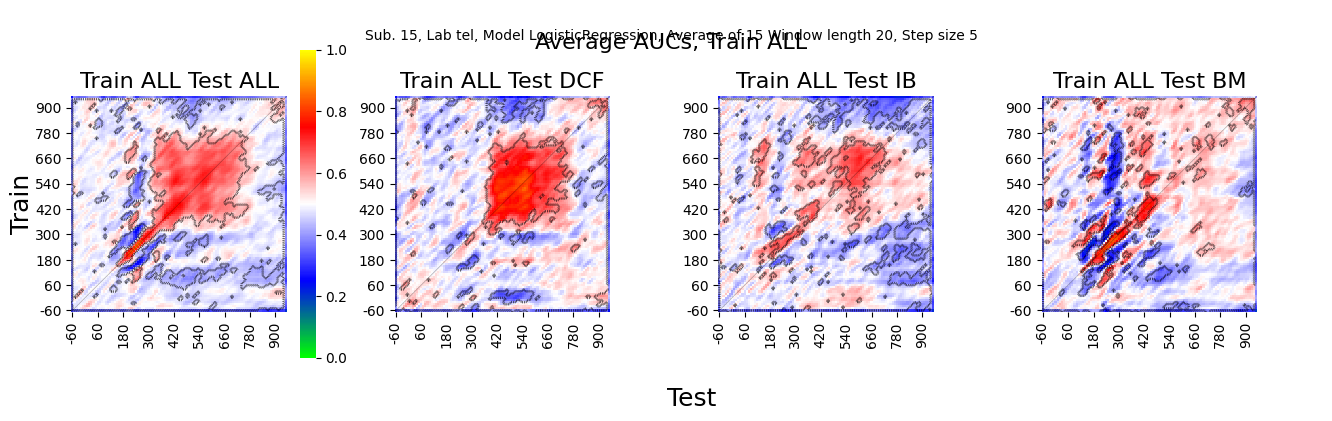

Loaded data from c:\GitHub\ML_models\ML_models\complete_run_reed_su52_LogisticRegression_BigSoup_all_and_indv_20_step_5_5fold_15avg_2024-04-27_21h-50m-40s.pkl
MODELS  0
WINDOWS  0
515
num of trains 1
num of tests 4
(1, 100, 4, 100)


<Figure size 1200x1200 with 0 Axes>

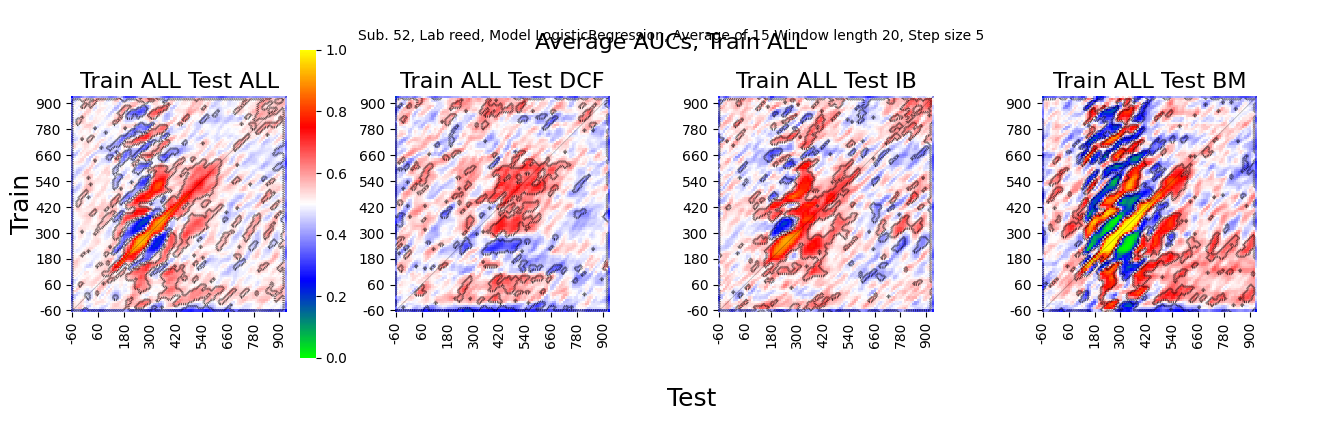

Loaded data from c:\GitHub\ML_models\ML_models\complete_run_reed_su38_LogisticRegression_BigSoup_all_and_indv_20_step_5_5fold_15avg_2024-04-27_21h-18m-01s.pkl
MODELS  0
WINDOWS  0
515
num of trains 1
num of tests 4
(1, 100, 4, 100)


<Figure size 1200x1200 with 0 Axes>

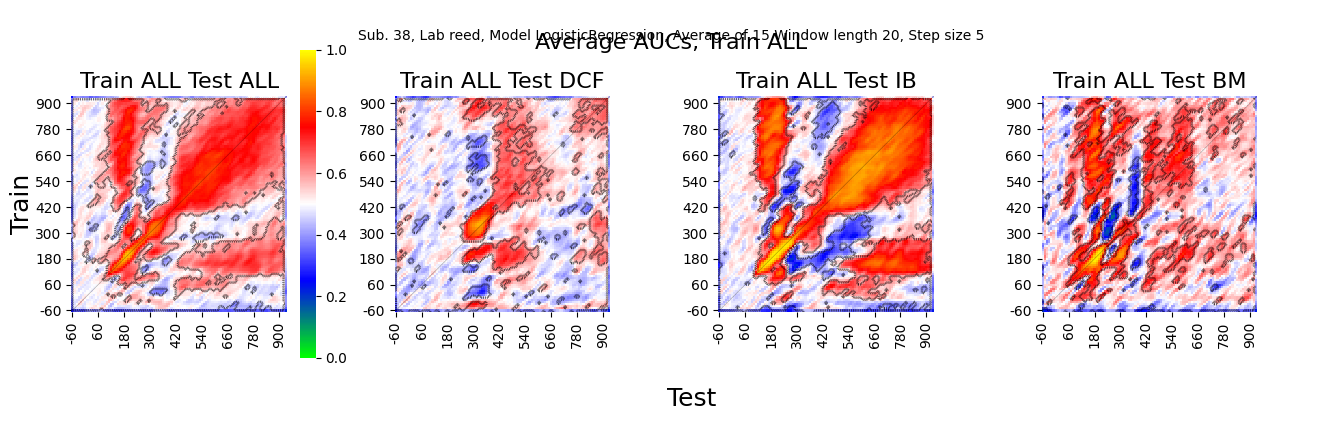

Loaded data from c:\GitHub\ML_models\ML_models\complete_run_reed_su37_LogisticRegression_BigSoup_all_and_indv_20_step_5_5fold_15avg_2024-04-27_20h-46m-36s.pkl
MODELS  0
WINDOWS  0
515
num of trains 1
num of tests 4
(1, 100, 4, 100)


<Figure size 1200x1200 with 0 Axes>

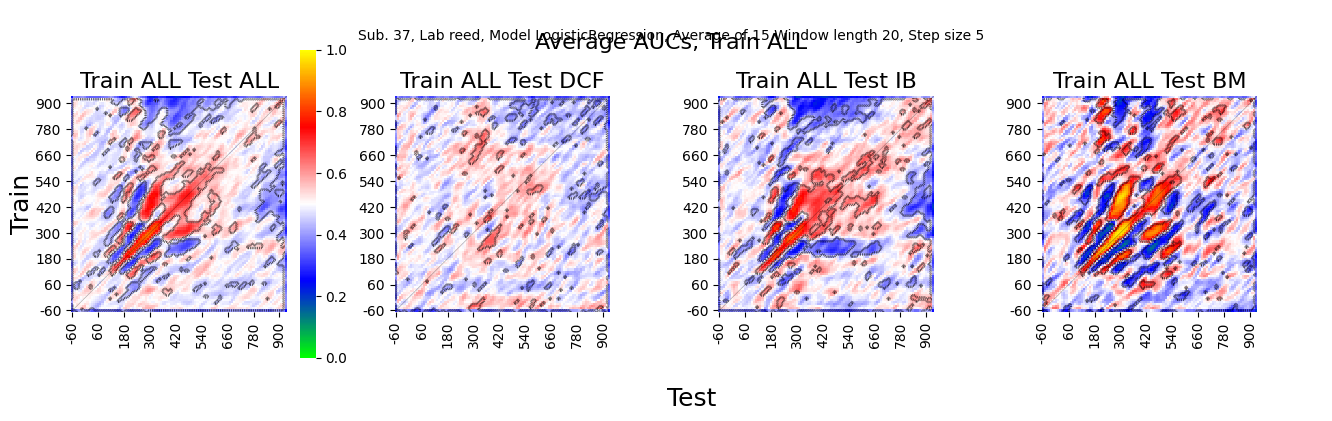

Loaded data from c:\GitHub\ML_models\ML_models\complete_run_reed_su28_LogisticRegression_BigSoup_all_and_indv_20_step_5_5fold_15avg_2024-04-27_20h-16m-33s.pkl
MODELS  0
WINDOWS  0


KeyboardInterrupt: 

In [91]:
import os
import pickle

def load_last_pickle(folder_path,number):
    # Get a list of all pickle files in the folder
    pickle_files = [file for file in os.listdir(folder_path) if file.endswith(".pkl")]

    # Check if there are any pickle files in the folder
    if not pickle_files:
        print("No pickle files found in the folder.")
        return None

    # Sort the pickle files by modification time to get the last one
    pickle_files.sort(key=lambda x: os.path.getmtime(os.path.join(folder_path, x)), reverse=True)

    # Get the path of the last pickle file
    last_pickle_path = os.path.join(folder_path, pickle_files[number])

    # Load the data from the last pickle file
    data = []
    with open(last_pickle_path, 'rb') as file:
        while True:
            try:
                chunk = pickle.load(file)
                data.extend(chunk)
            except EOFError:
                break

    print(f"Loaded data from {last_pickle_path}")
    return data

# Replace 'your_folder_path' with the actual path of your folder containing pickle files
folder_path = os.getcwd()
print(folder_path)
for i in range(0,8):
    this_pipeline = load_last_pickle(folder_path,i)
    print_all_models(this_pipeline)


#model_outputsy = load_last_pickle(folder_path,0)


# with open(f'Triangulation names {models_name} {window_sizes} wins.pkl', 'rb') as f:
#         hyper_names = pickle.load(f)

In [50]:
"""

The order of data inside the This_Pipeline goes:

#1 models
#2 averages
#3 windows
#4 splits
#5 list with 1 run

"""

model_outputs_array = np.array(this_pipeline)
model_outputs_array.shape

(1, 1, 1, 5, 1)

MODELS  0
WINDOWS  0
515
(3, 100, 3, 100)


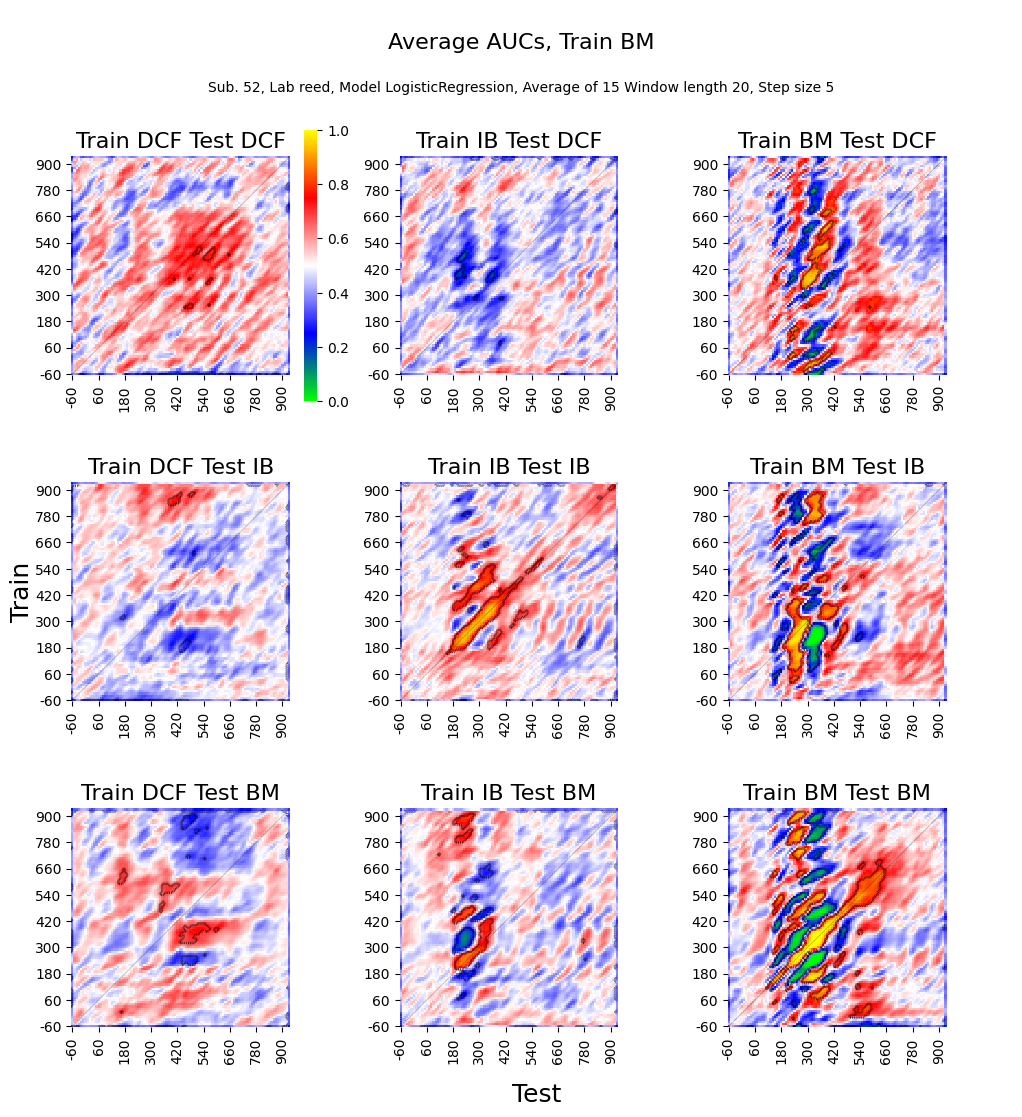

MODELS  1
WINDOWS  0
515
(3, 100, 3, 100)


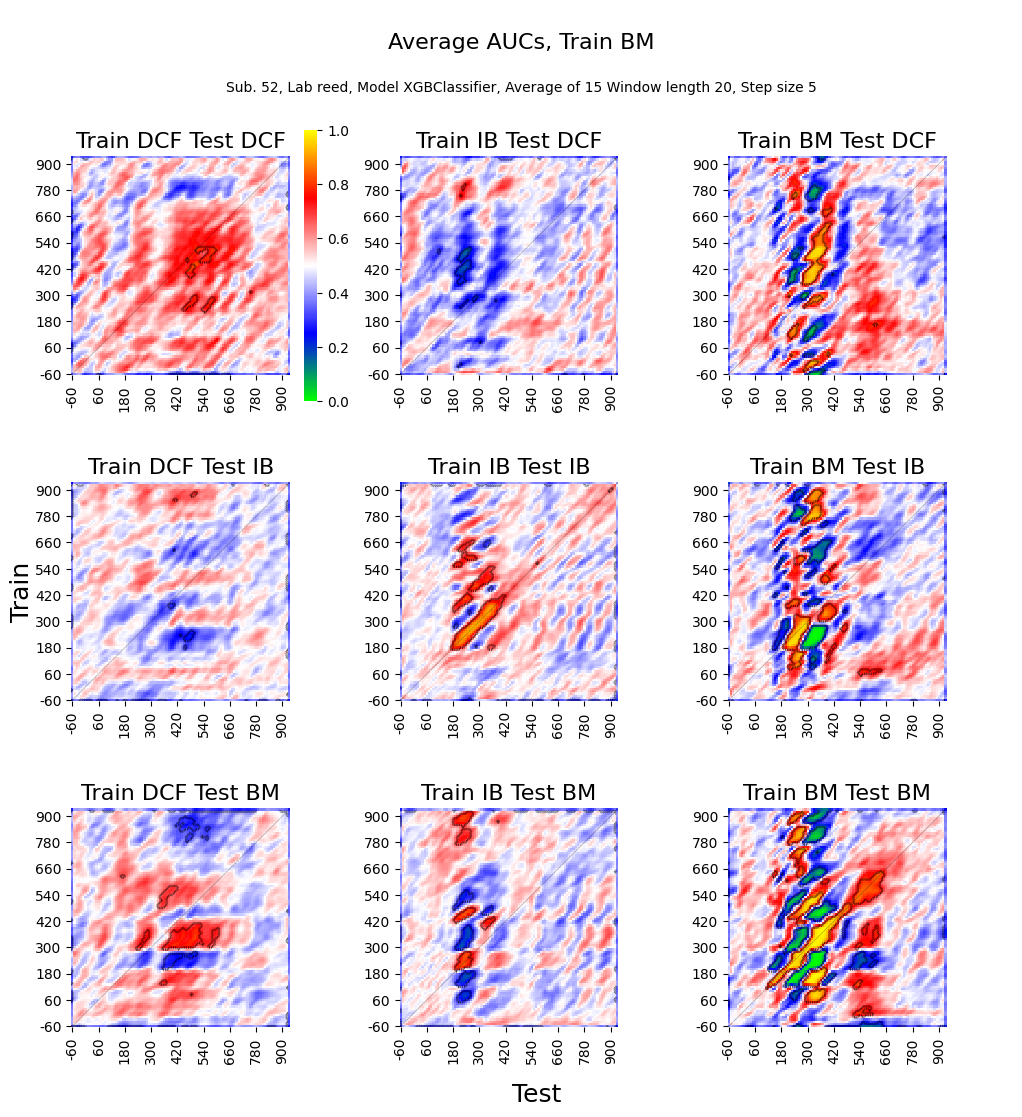

In [ ]:
# """

# The order of data inside the This_Pipeline goes:

# #1 models
# #2 averages
# #3 windows
# #4 splits
# #5 list with 1 run

# """
# #def print_all_models(this_pipeline):
# model_outputs_array = np.array(this_pipeline)
# model_outputs_array.shape
# # LETS PRINT SOME GRAPHS

# for i in range(model_outputs_array.shape[0]):
#     # i = number of MODELS
    
#     print('MODELS ',i)
#     for j in range(model_outputs_array.shape[1]):
#         # j - number of AVERAGES
#         # WINDOWS
#         print('WINDOWS ',j)
#         for k in range(model_outputs_array.shape[2]):
#             # k = number of WINDOWS
#             print_timebytime(model_outputs_array[i,j,k,:,:])
#             #print_time_window_three_new2(step_size[j],splits_accuracy_matrix,window_sizes[j],model_outputs_array4[:,:,5],'AUC',model_outputs_array4[:,:,7],round_robins[:], True, model_outputs_array4[:,:,4])
                

[[-0.32266214 -0.23933407 -0.18495615 ... -0.160253   -0.06673514
   0.13910827]]
(59, 20)


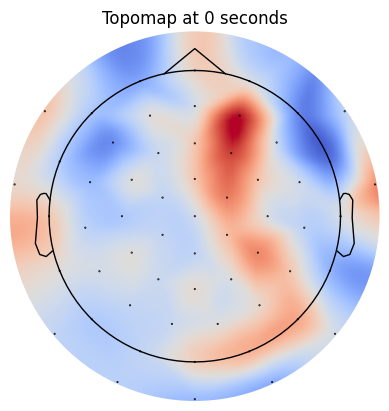

[[-0.30760629 -0.11697586  0.01577394 ...  0.04154505 -0.06341633
  -0.32450817]]
(59, 20)


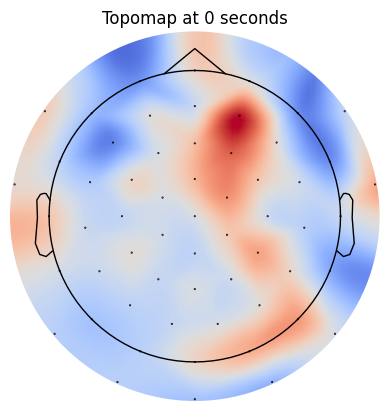

[[ 0.08360956  0.02709751 -0.0472364  ... -0.08433339 -0.32176401
  -0.56619614]]
(59, 20)


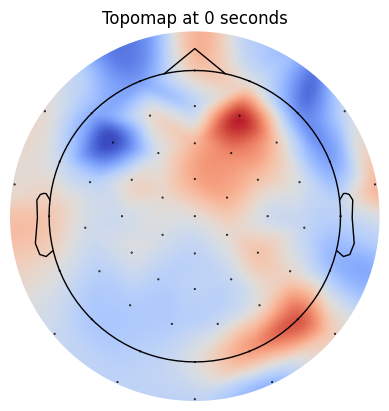

[[-0.03538109 -0.11232635 -0.13287809 ... -0.0588986   0.04138157
   0.11725574]]
(59, 20)


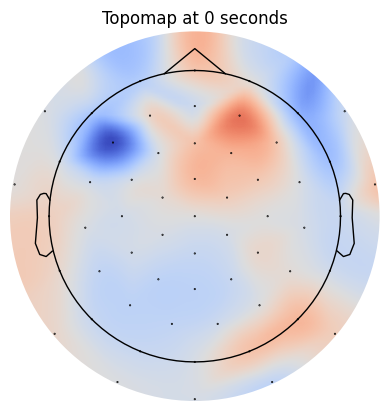

[[-0.32948059 -0.14393242 -0.00847688 ...  0.1111639   0.00746334
  -0.12403726]]
(59, 20)


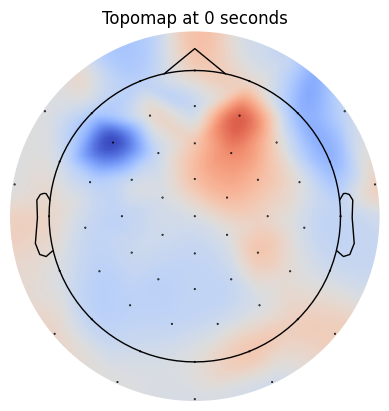

[[-0.17464641  0.01404426  0.12821704 ... -0.12272838 -0.07859678
  -0.02349788]]
(59, 20)


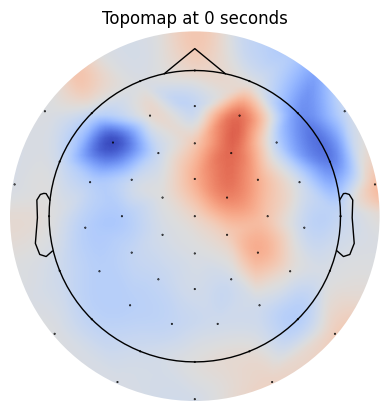

[[ 0.1000066   0.07797084  0.02305784 ... -0.05546243 -0.11594711
  -0.18249912]]
(59, 20)


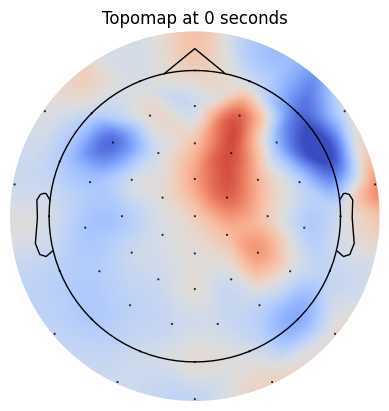

[[-0.25226581 -0.27015036 -0.25113885 ... -0.01846926  0.16780811
   0.38425108]]
(59, 20)


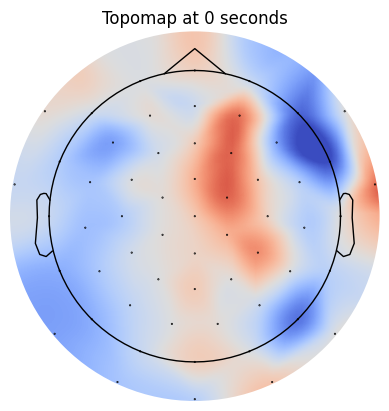

[[-0.17164546  0.01631494  0.16842924 ...  0.2488843   0.11650284
  -0.09743241]]
(59, 20)


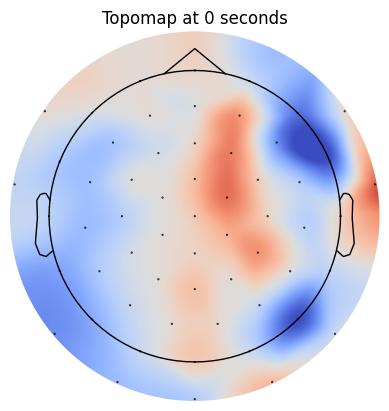

[[ 0.543081    0.41492586  0.27796948 ... -0.13384424 -0.15858044
  -0.11219317]]
(59, 20)


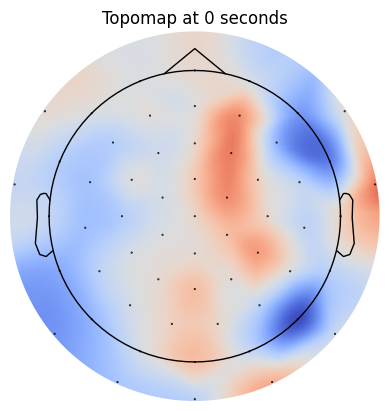

[[0.29281099 0.26991546 0.28950147 ... 0.09171995 0.1639337  0.19219142]]
(59, 20)


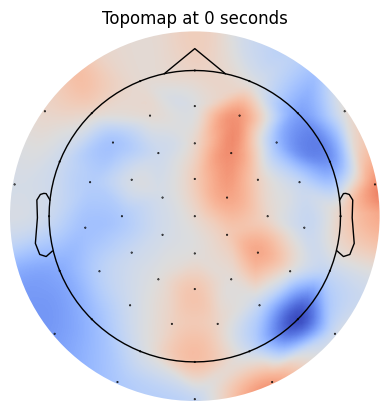

[[ 0.18538638  0.21645233  0.15150654 ...  0.04289884 -0.06877276
  -0.16652411]]
(59, 20)


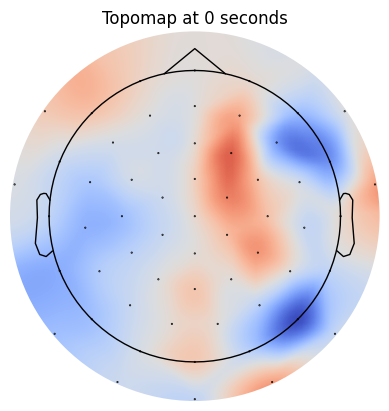

[[ 0.01376741 -0.10100121 -0.15090453 ...  0.0040934   0.12261723
   0.26569223]]
(59, 20)


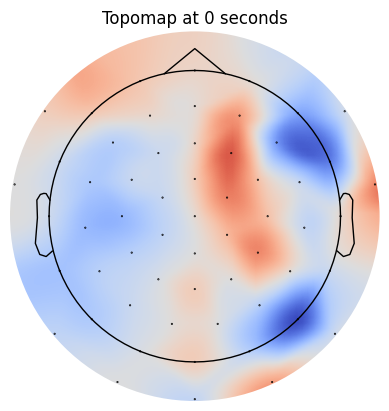

[[-0.20494223 -0.00109631  0.13382744 ...  0.31898638  0.21682916
  -0.01149525]]
(59, 20)


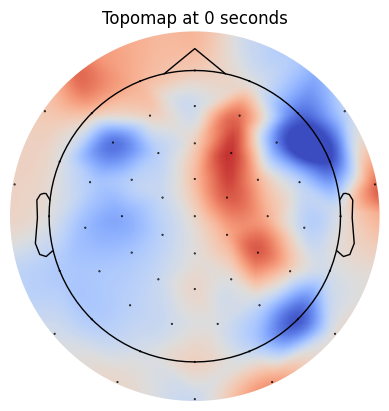

[[ 0.27042956  0.0917676  -0.04196552 ... -0.1122915  -0.1519783
  -0.09572948]]
(59, 20)


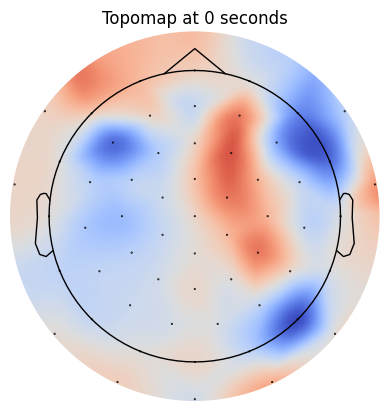

[[-0.02719683  0.00720515  0.08676418 ...  0.17457503  0.34466729
   0.4523818 ]]
(59, 20)


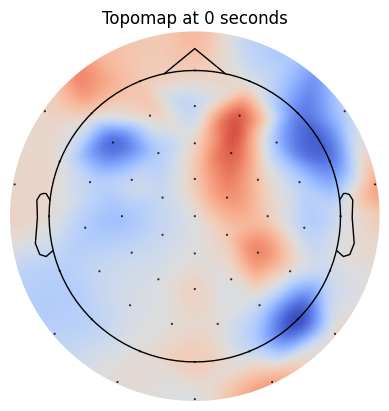

[[ 0.21316601  0.21820473  0.15161716 ...  0.28539121 -0.048804
  -0.51813876]]
(59, 20)


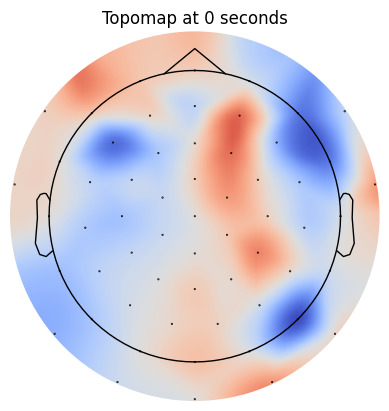

[[ 0.15651011 -0.00074207 -0.07247738 ... -0.11225058 -0.22043332
  -0.40270088]]
(59, 20)


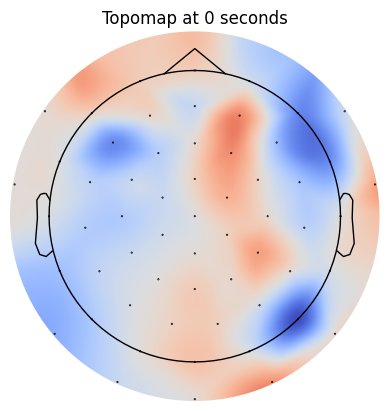

[[-0.11082408 -0.08503703 -0.06921859 ... -0.21841788 -0.41516606
  -0.61407144]]
(59, 20)


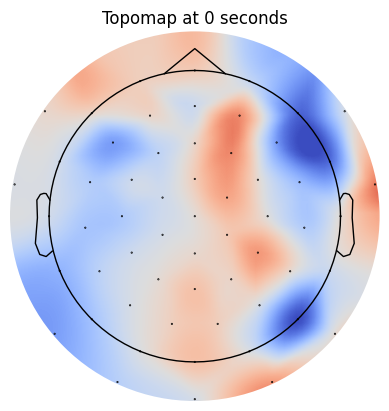

[[-0.08353942 -0.09916107 -0.09986734 ... -0.32447317 -0.18390014
   0.03423936]]
(59, 20)


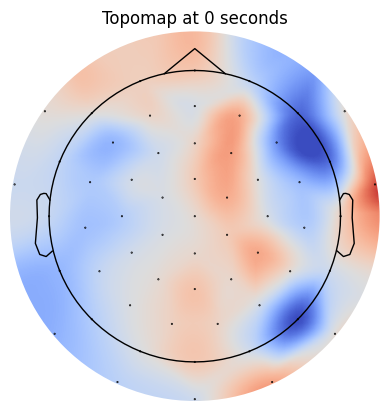

In [25]:
model_outputs_array[0,0,0,:,0]
for i in range(30,50):
    coef = model_outputs_array[0,0,0,0,0].models[i].coef_
    print_mean_coeff(coef,0)
#coef = model_outputs_array[0,0,0,0,0].models[i].coef_
# print_mean_coeff(coef,0)
# coef = model_outputs_array[0,0,0,0,0].models[35].coef_
# print_mean_coeff(coef,0)
# coef = model_outputs_array[0,0,0,0,0].models[36].coef_
# print_mean_coeff(coef,0)


In [51]:
aucs_array = np.array([run.aucs for run in model_outputs_array[0,0,0,:,0]])
cis_array = np.array([run.cis for run in model_outputs_array[0,0,0,:,0]])

In [100]:
y_preds = np.array([run.tests_predictions for run in model_outputs_array[0,0,0,:,0]])
y_tests = np.array([run.y_tests for run in model_outputs_array[0,0,0,:,0]])

C:\Users\User\AppData\Local\Temp\ipykernel_44284\944237287.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_preds = np.array([run.tests_predictions for run in model_outputs_array[0,0,0,:,0]])
C:\Users\User\AppData\Local\Temp\ipykernel_44284\944237287.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_tests = np.array([run.y_tests for run in model_outputs_array[0,0,0,:,0]])


In [106]:
print(y_tests.shape)

(5, 1, 1)


In [64]:
lower_cis = np.zeros([aucs_array.shape[1],aucs_array.shape[3]])
upper_cis = np.zeros([aucs_array.shape[1],aucs_array.shape[3]])
#p_values = np.zeros_like(heatmap_data)
bootstrap_aucs = []
for i in range(aucs_array.shape[1]):
    for j in range(aucs_array.shape[2]):
        for k in range(aucs_array.shape[3]):
            #for l in range(aucs_array.shape[-4]):
                    #subj, splits, trains, values, test, values 
            auc_value = np.squeeze(aucs_array[:,i,j,k])
            #print(auc_value)
            # Perform one-sample t-test against chance level
            bootstrap_sample = np.random.choice(auc_value, size=auc_value.shape[0], replace=True)
            #print(bootstrap_sample)
            # Calculate the mean of the bootstrap sample and append it to bootstrap_means
            bootstrap_aucs.append(np.mean(bootstrap_sample))
            # Calculate confidence interval
            ci_lower, ci_upper = np.percentile(bootstrap_sample, [2.5, 97.5])
            lower_cis[k,i] = ci_lower
            upper_cis[k,i] = ci_upper



[0.24262735 0.59585492 0.59585492 0.49330759 0.36841052]
[0.42367067 0.74908942 0.74908942 0.42367067 0.74908942]
[0.67789969 0.45348963 0.46284607 0.50898773 0.50898773]
[0.52342388 0.35237468 0.49250095 0.6393373  0.55755282]
[0.41718198 0.61789298 0.61789298 0.41718198 0.53491106]
[0.55713679 0.35160024 0.35160024 0.46018145 0.55713679]
[0.51977603 0.43490347 0.5029295  0.5029295  0.43490347]
[0.53194444 0.56041061 0.56041061 0.56041061 0.47419924]
[0.52279001 0.38950046 0.57321937 0.38950046 0.57321937]
[0.43807978 0.43807978 0.3850203  0.44311085 0.51837028]
[0.5408939  0.42172181 0.47245692 0.5408939  0.47245692]
[0.46618898 0.46515523 0.46515523 0.5142029  0.5142029 ]
[0.54959046 0.55456638 0.55456638 0.57822596 0.55456638]
[0.44503692 0.44503692 0.36613779 0.44503692 0.53788076]
[0.38535534 0.44859375 0.4498534  0.44859375 0.45875   ]
[0.44025157 0.44025157 0.44025157 0.51282051 0.44855113]
[0.42440207 0.61523561 0.61523561 0.57999679 0.57999679]
[0.52977487 0.52977487 0.529774

In [72]:
print(lower_cis.shape)

(102, 102)
